In [1]:

import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("colorblind")

In [2]:
# If None, all the data will be plotted, otherwise only the data for the specified backend size and/or qubit size will be plotted
backend_size = None
qubit_size = None

In [3]:
exp_dirs = ["exponential_1k_shots", "exponential_5k_shots", "exponential_10k_shots"]
alt_dirs = ["complete_exp_v1_vm_1k", "complete_exp_v1_vm_5k", "complete_exp_vm_1"]
alt_policies = ["cutshot.src.policies.divider", "cutshot.src.policies.multiplier"]

exp_legend = exp_dirs

exp_legend = ["1k", "5k", "10k"]

In [4]:
colors = {
    "vanilla": sns.color_palette()[0],
    "cc": sns.color_palette()[1],
    "sw": sns.color_palette()[2],
    "cc_sw": sns.color_palette()[3],
    
    "cc_all": sns.color_palette()[4],
    "sw_without": sns.color_palette()[2],
    "sw_after": sns.color_palette()[3],
}

legend = {
    "vanilla": "Naive",
    "cc": "Only Circuit Cutting",
    "sw": "Only Shot-Wise",
    "cc_sw": "Cut&Shoot",
    
    "cc_all": "Circuit Cutting",
    "sw_without": "Shot-Wise (Without Circuit Cutting)",
    "sw_after": "Shot-Wise (After Circuit Cutting)",
}

dir = "./experiments_results/"

paths = [dir + exp_dir + "/" for exp_dir in exp_dirs]
alt_paths = [dir + alt_dir + "/" for alt_dir in alt_dirs]
paths, alt_paths

(['./experiments_results/exponential_1k_shots/',
  './experiments_results/exponential_5k_shots/',
  './experiments_results/exponential_10k_shots/'],
 ['./experiments_results/complete_exp_v1_vm_1k/',
  './experiments_results/complete_exp_v1_vm_5k/',
  './experiments_results/complete_exp_vm_1/'])

In [5]:
plots_dir = "./plots/"

if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

In [6]:
circuit_qubits = {}

for path in paths:
    for file in os.listdir(path+"perf_exp_vals/"):
        if file.endswith(".json"):
            circuit_id = "_".join(file.split("_")[:5])
            file_json = json.load(open(path+"perf_exp_vals/"+file))
            qubits = file_json["n_qubits"]
            circuit_qubits[circuit_id] = int(qubits)
        else:
            print(f"WARNING: {file} is not a json file")

In [7]:
exp_data = []
exp_data_dfs = []

for path in paths + alt_paths:
    for file in os.listdir(path+"vanilla"):
        if file.endswith(".json"):
            circuit_id = "_".join(file.split("_")[3:8])
            qubits = circuit_qubits[circuit_id]
            file_json = json.load(open(path+"vanilla/"+file))   
            num_backends = len(file_json["params"]["backends"])
            time_total = file_json["times"]["time_total"]
            execution_time = file_json["times"]["time_execution"]
            
            for provider, backends in file_json["error"].items():
                for backend, res in backends.items():
                    backend_name = provider + "/" + backend
                    error = res[list(res.keys())[0]]
                    
                    shots = sum(x[1] for x in file_json["stats"]["dispatch"][provider][backend])
                    cut_strategy = file_json["params"]["cut_strategy"] if "cut_strategy" in file_json["params"] else None
                    shots_allocation = file_json["params"]["shots_allocation"] if "shots_allocation" in file_json["params"] else None
                    shot_wise_policy = file_json["params"]["shot_wise_policy"] if "shot_wise_policy" in file_json["params"] else None
                    
                    exp_data.append({"circuit_id": circuit_id, "qubits": qubits, "backends": [backend_name], "num_backends": 1, "error": error, "time": time_total, "shots": shots, "circuit_cutting": False, "shot-wise": False, "cut_strategy": cut_strategy, "shots_allocation": shots_allocation, "shot_wise_policy": shot_wise_policy, "strategy": "vanilla", "circuit_cutting_overhead": None, "shot_wise_overhead": None, "execution_time": execution_time, "time_total": time_total})
        else:
            print(f"WARNING: {file} is not a json file")
            
    for file in os.listdir(path+"cc"):
        if file.endswith(".json"):
            circuit_id = "_".join(file.split("_")[3:8])
            qubits = circuit_qubits[circuit_id]
            file_json = json.load(open(path+"cc/"+file))   
            num_backends = len(file_json["params"]["backends"])
            time_total = file_json["times"]["time_total"]      
            execution_time = file_json["times"]["time_execution"]
            
            
            for provider, backends in file_json["error"].items():
                for backend, res in backends.items():
                    backend_name = provider + "/" + backend
                    error = res[list(res.keys())[0]]
                    
                    shots = sum(x[1] for x in file_json["stats"]["dispatch"][provider][backend])
                    
                    cut_strategy = file_json["params"]["cut_strategy"] if "cut_strategy" in file_json["params"] else None
                    shots_allocation = file_json["params"]["shots_allocation"] if "shots_allocation" in file_json["params"] else None
                    shot_wise_policy = file_json["params"]["shot_wise_policy"] if "shot_wise_policy" in file_json["params"] else None
                    
                    circuit_cutting_overhead = file_json["times"]["time_cutting"] + file_json["times"]["time_sew"][provider][backend] + file_json["times"]["time_allocation"]
                    
                    exp_data.append({"circuit_id": circuit_id, "qubits": qubits, "backends": [backend_name], "num_backends": 1, "error": error, "time": time_total, "shots": shots, "circuit_cutting": True, "shot-wise": False, "cut_strategy": cut_strategy, "shots_allocation": shots_allocation, "shot_wise_policy": shot_wise_policy, "strategy": "cc", "circuit_cutting_overhead": circuit_cutting_overhead, "shot_wise_overhead": None, "execution_time": execution_time, "time_total": time_total})
        else:
            print(f"WARNING: {file} is not a json file")
            
    for file in os.listdir(path+"sw"):
        if file.endswith(".json"):
            circuit_id = "_".join(file.split("_")[3:8])
            qubits = circuit_qubits[circuit_id]
            file_json = json.load(open(path+"sw/"+file))   
            num_backends = len(file_json["params"]["backends"])
            time_total = file_json["times"]["time_total"]
        
            shots = 0
            for provider, backends in file_json["stats"]["dispatch"].items():
                for backend, shots_list in backends.items():
                    shots += sum(x[1] for x in shots_list)
                    
            backends = []
            for provider, backend in file_json["params"]["backends"]:
                backends.append(provider + "/" + backend)
                
            error = file_json["error"]
            
            execution_time = file_json["times"]["time_execution"]
            shot_wise_overhead = file_json["times"]["time_dispatch"] + file_json["times"]["time_merge"]

            cut_strategy = file_json["params"]["cut_strategy"] if "cut_strategy" in file_json["params"] else None
            shots_allocation = file_json["params"]["shots_allocation"] if "shots_allocation" in file_json["params"] else None
            shot_wise_policy = file_json["params"]["shot_wise_policy"] if "shot_wise_policy" in file_json["params"] else None
            
            exp_data.append({"circuit_id": circuit_id, "qubits": qubits, "backends": backends, "num_backends": num_backends, "error": error, "time": time_total, "shots": shots, "circuit_cutting": False, "shot-wise": True, "cut_strategy": cut_strategy, "shots_allocation": shots_allocation, "shot_wise_policy": shot_wise_policy, "strategy": "sw", "circuit_cutting_overhead": None, "shot_wise_overhead": shot_wise_overhead, "execution_time": execution_time, "time_total": time_total})
        else:
            print(f"WARNING: {file} is not a json file")
            
    for file in os.listdir(path+"cc_sw"):
        if file.endswith(".json"):
            circuit_id = "_".join(file.split("_")[4:9])
            qubits = circuit_qubits[circuit_id]
            file_json = json.load(open(path+"cc_sw/"+file))   
            num_backends = len(file_json["params"]["backends"])
            time_total = file_json["times"]["time_total"]
        
            shots = 0
            for provider, backends in file_json["stats"]["dispatch"].items():
                for backend, shots_list in backends.items():
                    shots += sum(x[1] for x in shots_list)
                    
            backends = []
            for provider, backend in file_json["params"]["backends"]:
                backends.append(provider + "/" + backend)
                
            error = file_json["error"]
            
            execution_time = file_json["times"]["time_execution"]
            shot_wise_overhead = file_json["times"]["time_dispatch"] + file_json["times"]["time_merge"]
            circuit_cutting_overhead = file_json["times"]["time_cutting"] + file_json["times"]["time_sew"] + file_json["times"]["time_allocation"]

            cut_strategy = file_json["params"]["cut_strategy"] if "cut_strategy" in file_json["params"] else None
            shots_allocation = file_json["params"]["shots_allocation"] if "shots_allocation" in file_json["params"] else None
            shot_wise_policy = file_json["params"]["shot_wise_policy"] if "shot_wise_policy" in file_json["params"] else None
            
            exp_data.append({"circuit_id": circuit_id, "qubits": qubits, "backends": backends, "num_backends": num_backends, "error": error, "time": time_total, "shots": shots, "circuit_cutting": True, "shot-wise": True, "cut_strategy": cut_strategy, "shots_allocation": shots_allocation, "shot_wise_policy": shot_wise_policy, "strategy": "cc_sw", "circuit_cutting_overhead": circuit_cutting_overhead, "shot_wise_overhead": shot_wise_overhead, "execution_time": execution_time, "time_total": time_total})    
        else:
            print(f"WARNING: {file} is not a json file")


    _exp_data_df = pd.DataFrame(exp_data)
    _exp_data_df["error"] = _exp_data_df["error"].apply(lambda x: abs(x))
    
    exp_data_dfs.append(_exp_data_df)
    
exp_data_dfs

[            circuit_id  qubits  \
 0      n4_r2_k2_p1_s22      10   
 1     n2_r2_k1_p1_s127       5   
 2      n2_r2_k1_p1_s25       5   
 3     n2_r2_k1_p1_s136       5   
 4      n4_r2_k2_p1_s18      10   
 ...                ...     ...   
 9721  n2_r2_k1_p1_s127       5   
 9722  n2_r2_k1_p1_s113       5   
 9723    n4_r3_k1_p1_s2      14   
 9724  n2_r2_k1_p1_s127       5   
 9725   n4_r2_k2_p1_s24      10   
 
                                                backends  num_backends  \
 0                              [ibm_aer/aer.fake_cusco]             1   
 1                               [ibm_aer/aer.fake_kyiv]             1   
 2                           [ibm_aer/aer.fake_brisbane]             1   
 3                             [ibm_aer/aer.fake_quebec]             1   
 4                             [ibm_aer/aer.fake_quebec]             1   
 ...                                                 ...           ...   
 9721  [ibm_aer/aer.fake_kyoto, ibm_aer/aer.fake_osak...    

In [8]:
l_paths = len(paths)

new_dfs = []

for i, df in enumerate(exp_data_dfs):
    if i < l_paths:
        new_dfs.append((df, exp_data_dfs[i+l_paths]))
    else:
        break
    
__dfs = []
for d1, d2 in new_dfs:
    __dfs.append(pd.concat([d1, d2], ignore_index=True))
    
exp_data_dfs = __dfs


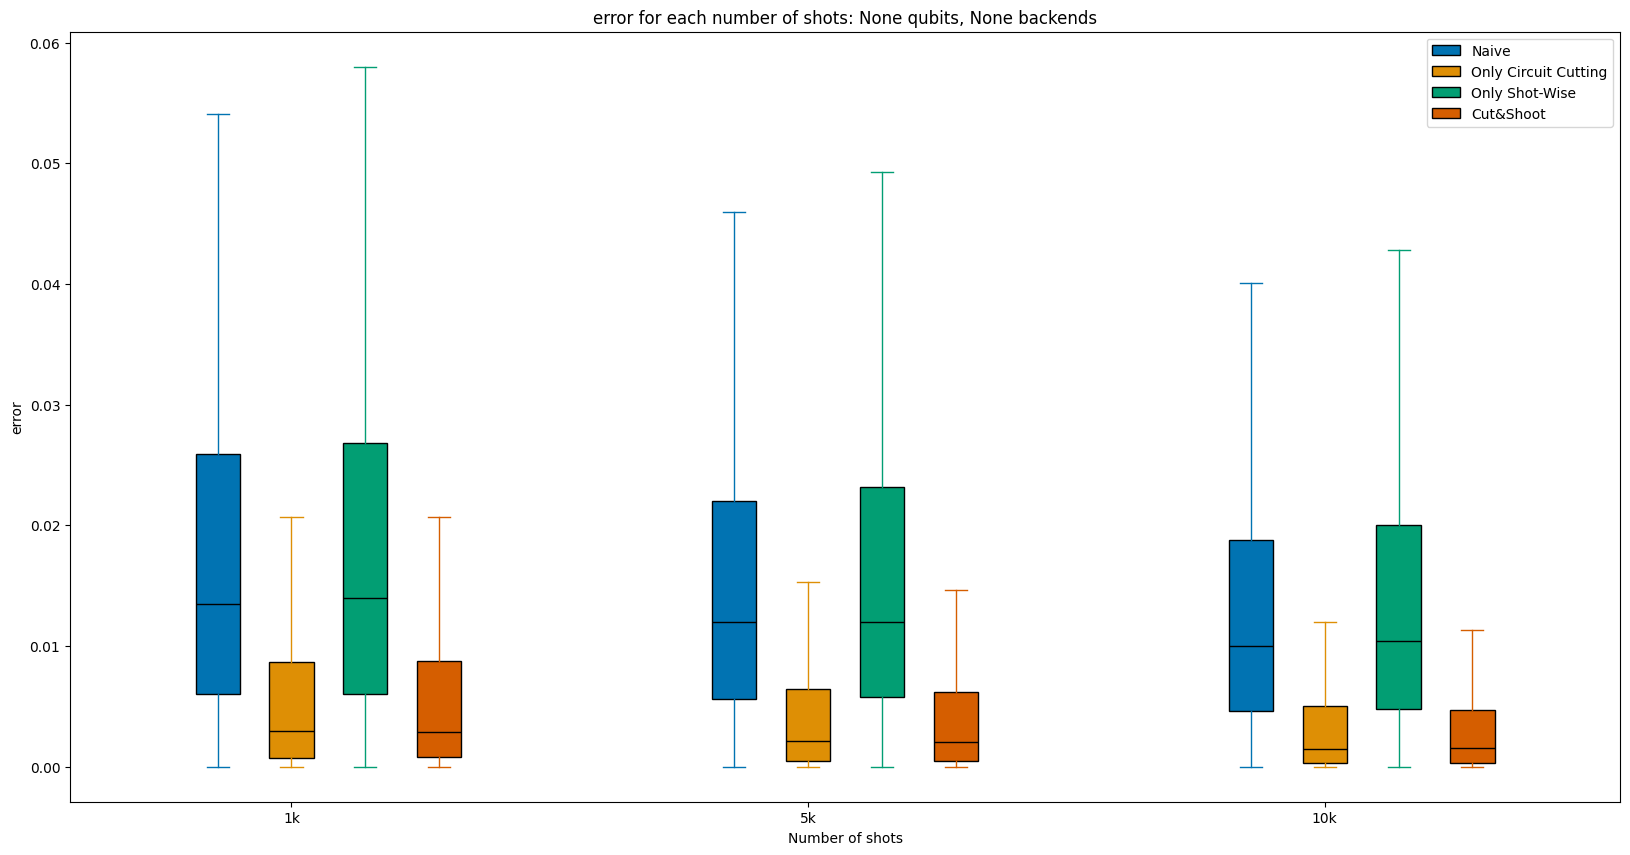

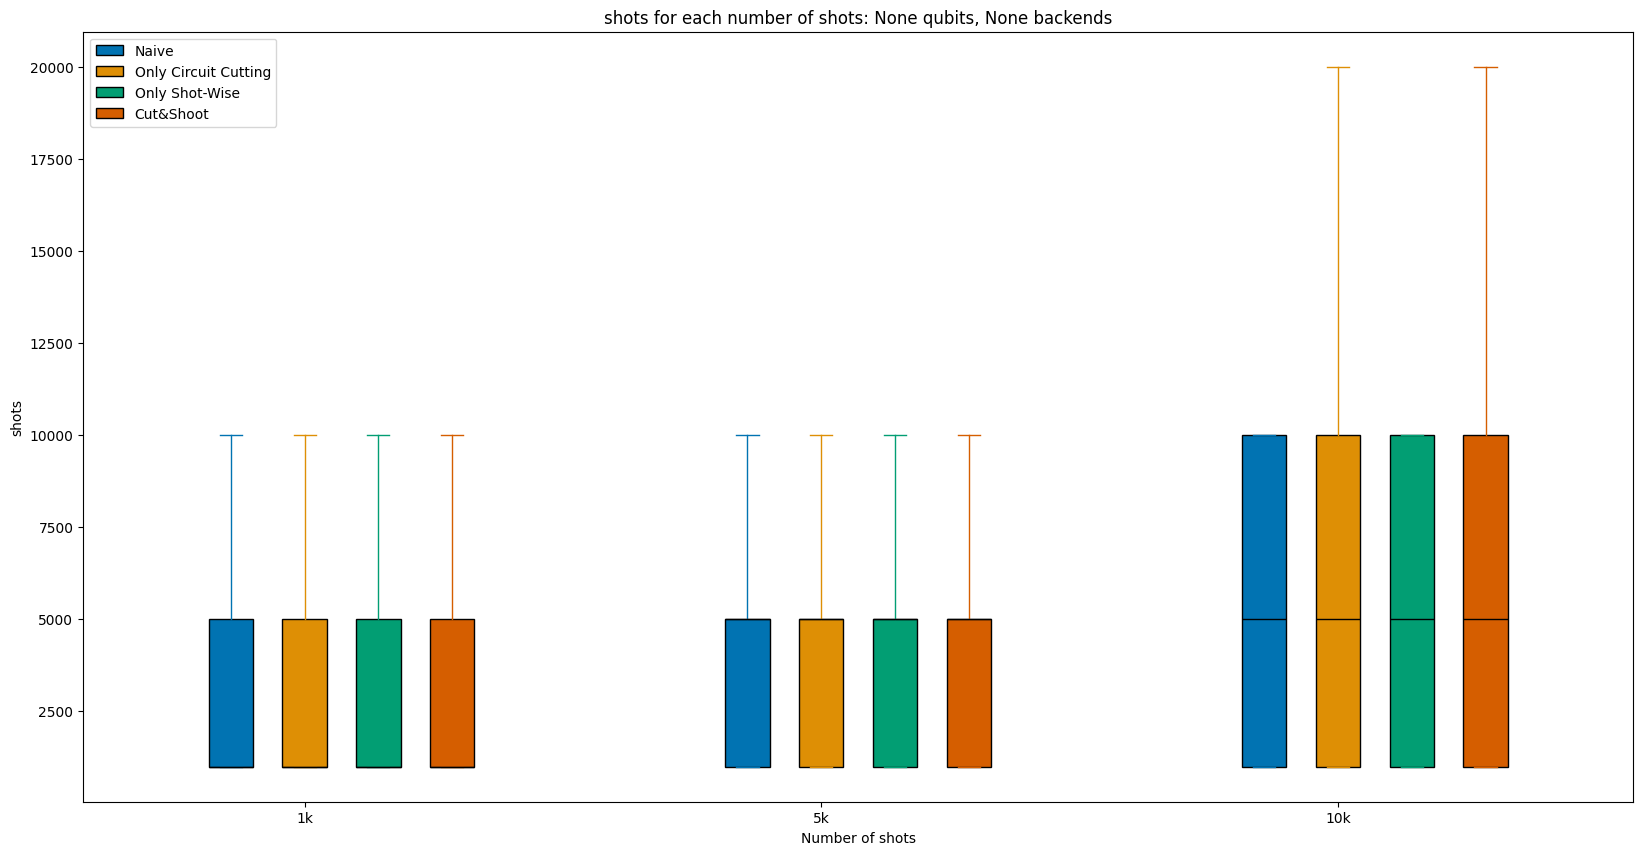

In [9]:
for attr in ["error", "shots"]:
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)
    pos = 0
    for exp_data_df, legend_name in zip(exp_data_dfs, exp_legend):
        for strategy in exp_data_df["strategy"].unique():
            data_strat = exp_data_df[exp_data_df["strategy"] == strategy]
            
            if qubit_size:
                data_strat = data_strat[data_strat["qubits"] == qubit_size]
            if backend_size and strategy not in ["vanilla", "cc"]:
                data_strat = data_strat[data_strat["num_backends"] == backend_size]
            
            if (len(data_strat) == 0 or data_strat.empty):
                print(f"No data for {legend_name} {strategy}")
                continue
            
            color = colors[strategy]
            ax.boxplot(data_strat[attr], positions=[pos], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
            pos += 0.25
        
        pos += 0.75
        
    ax.set_xlabel("Number of shots")
    ax.set_ylabel(attr)
    ax.set_title(f"{attr} for each number of shots: {qubit_size} qubits, {backend_size} backends")
    ax.set_xticks(np.arange(len(exp_data_dfs)) * 1.75 + 0.25)
    ax.set_xticklabels(exp_legend)
    ax.legend([plt.Rectangle((0,0),1,1,fc=colors[strategy], ec="black") for strategy in exp_data_df["strategy"].unique()], [legend[strategy] for strategy in exp_data_df["strategy"].unique()])
    plt.savefig(plots_dir + f"{attr}_full_{qubit_size}q_{backend_size}b.png")
    plt.show()



[None 'cutshot.src.policies.qubit_exp' 'cutshot.src.policies.2qgates_exp'
 'cutshot.src.policies.qubit_proportional' 'cutshot.src.policies.divider'
 'cutshot.src.policies.multiplier'
 'cutshot.src.policies.2qgates_proportional']
             circuit_id  qubits  \
120      n4_r3_k1_p1_s9      14   
122      n4_r3_k1_p1_s2      14   
123      n4_r3_k1_p1_s0      14   
124     n4_r2_k2_p1_s15      10   
126      n4_r3_k1_p1_s0      14   
...                 ...     ...   
40010    n4_r3_k1_p1_s0      14   
40013  n2_r2_k1_p1_s127       5   
40014  n2_r2_k1_p1_s113       5   
40015    n4_r3_k1_p1_s2      14   
40017   n4_r2_k2_p1_s24      10   

                                                backends  num_backends  \
120                              [ibm_aer/aer.fake_kyiv]             1   
122                              [ibm_aer/aer.fake_kyiv]             1   
123                          [ibm_aer/aer.fake_brisbane]             1   
124                             [ibm_aer/aer.fake_kyot

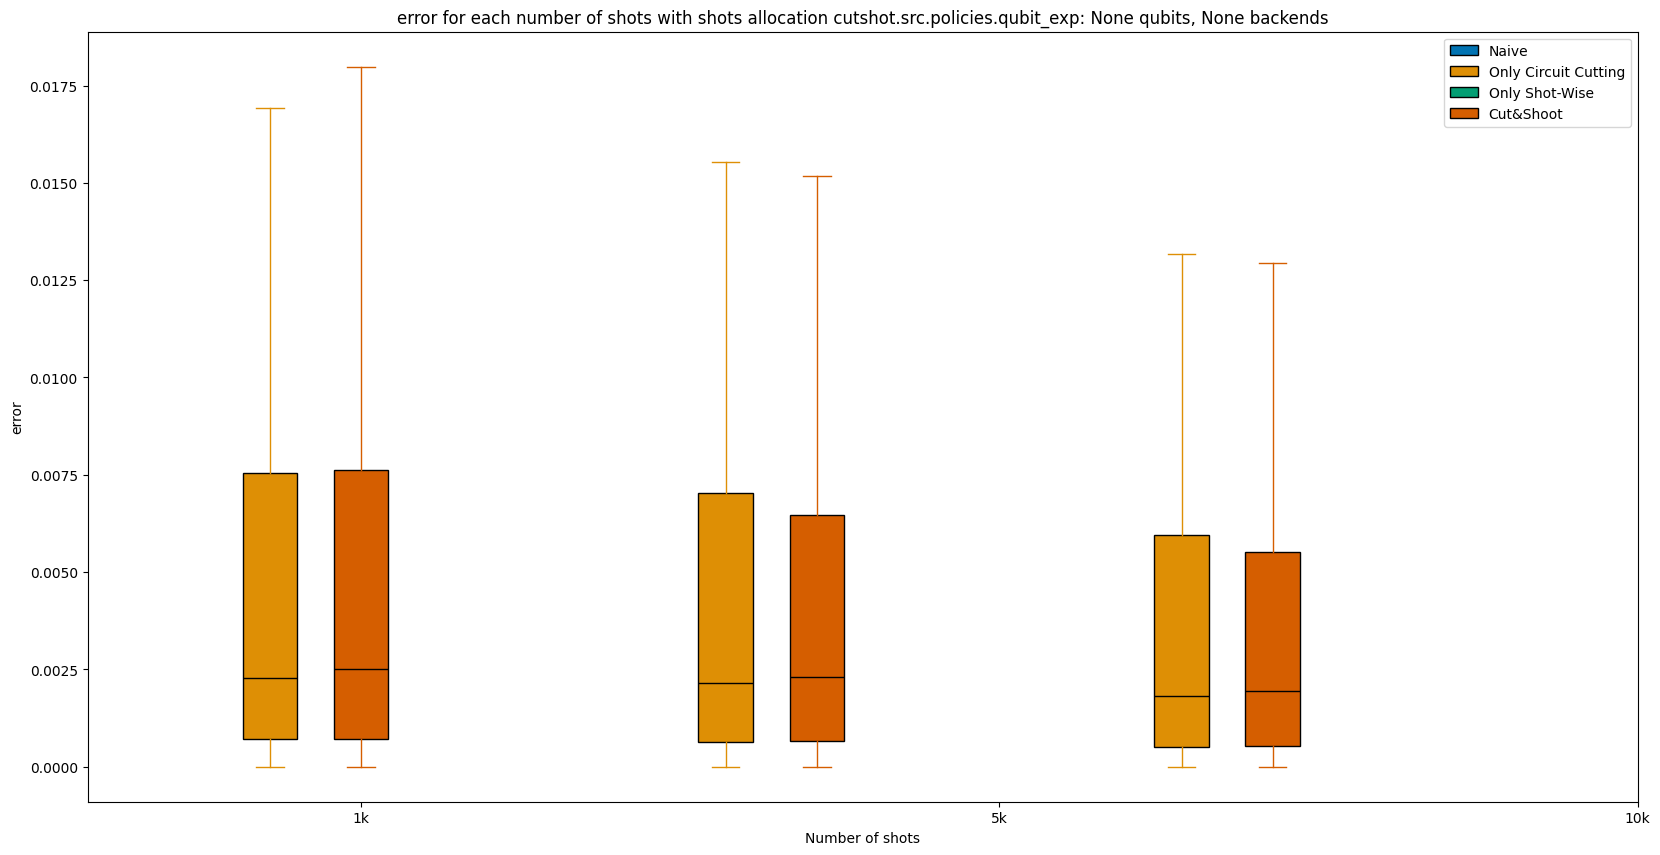

             circuit_id  qubits  \
120      n4_r3_k1_p1_s9      14   
122      n4_r3_k1_p1_s2      14   
123      n4_r3_k1_p1_s0      14   
124     n4_r2_k2_p1_s15      10   
126      n4_r3_k1_p1_s0      14   
...                 ...     ...   
40010    n4_r3_k1_p1_s0      14   
40013  n2_r2_k1_p1_s127       5   
40014  n2_r2_k1_p1_s113       5   
40015    n4_r3_k1_p1_s2      14   
40017   n4_r2_k2_p1_s24      10   

                                                backends  num_backends  \
120                              [ibm_aer/aer.fake_kyiv]             1   
122                              [ibm_aer/aer.fake_kyiv]             1   
123                          [ibm_aer/aer.fake_brisbane]             1   
124                             [ibm_aer/aer.fake_kyoto]             1   
126                             [ibm_aer/aer.fake_osaka]             1   
...                                                  ...           ...   
40010  [ibm_aer/aer.fake_brisbane, ibm_aer/aer.fake_k...     

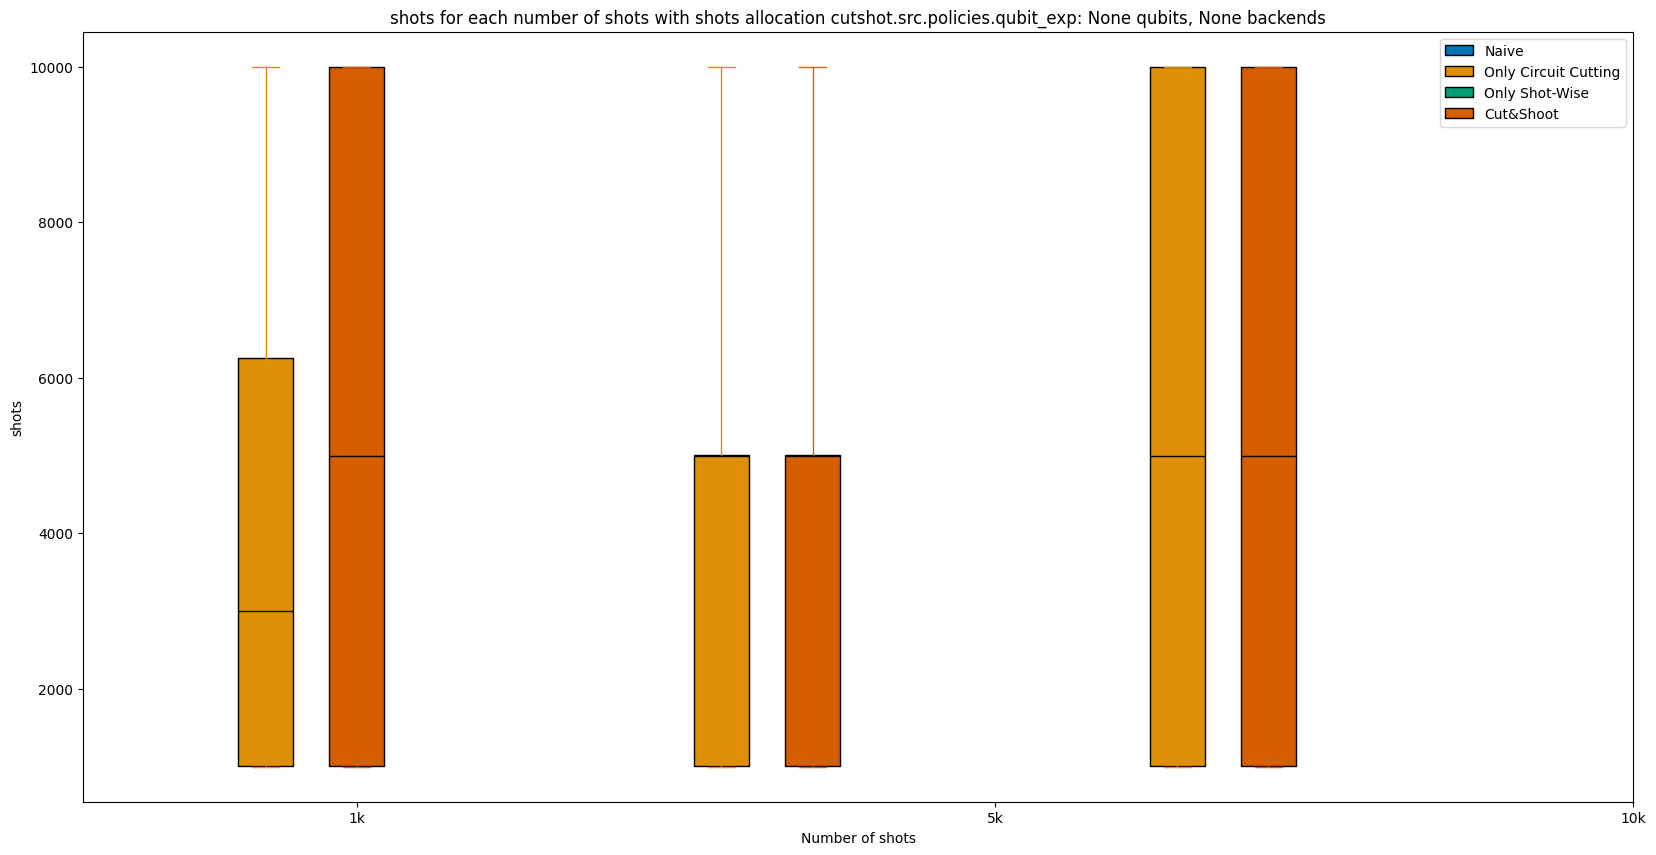

             circuit_id  qubits  \
121     n4_r2_k2_p1_s15      10   
125     n4_r2_k2_p1_s18      10   
127    n2_r2_k1_p1_s136       5   
130     n2_r2_k1_p1_s25       5   
133    n2_r2_k1_p1_s113       5   
...                 ...     ...   
40004   n4_r2_k2_p1_s24      10   
40009   n4_r2_k2_p1_s27      10   
40011  n2_r2_k1_p1_s127       5   
40012   n4_r2_k2_p1_s18      10   
40016  n2_r2_k1_p1_s127       5   

                                                backends  num_backends  \
121                          [ibm_aer/aer.fake_kawasaki]             1   
125                        [ibm_aer/aer.fake_sherbrooke]             1   
127                             [ibm_aer/aer.fake_cusco]             1   
130                             [ibm_aer/aer.fake_kyoto]             1   
133                             [ibm_aer/aer.fake_osaka]             1   
...                                                  ...           ...   
40004  [ibm_aer/aer.fake_kyoto, ibm_aer/aer.fake_cusc...     

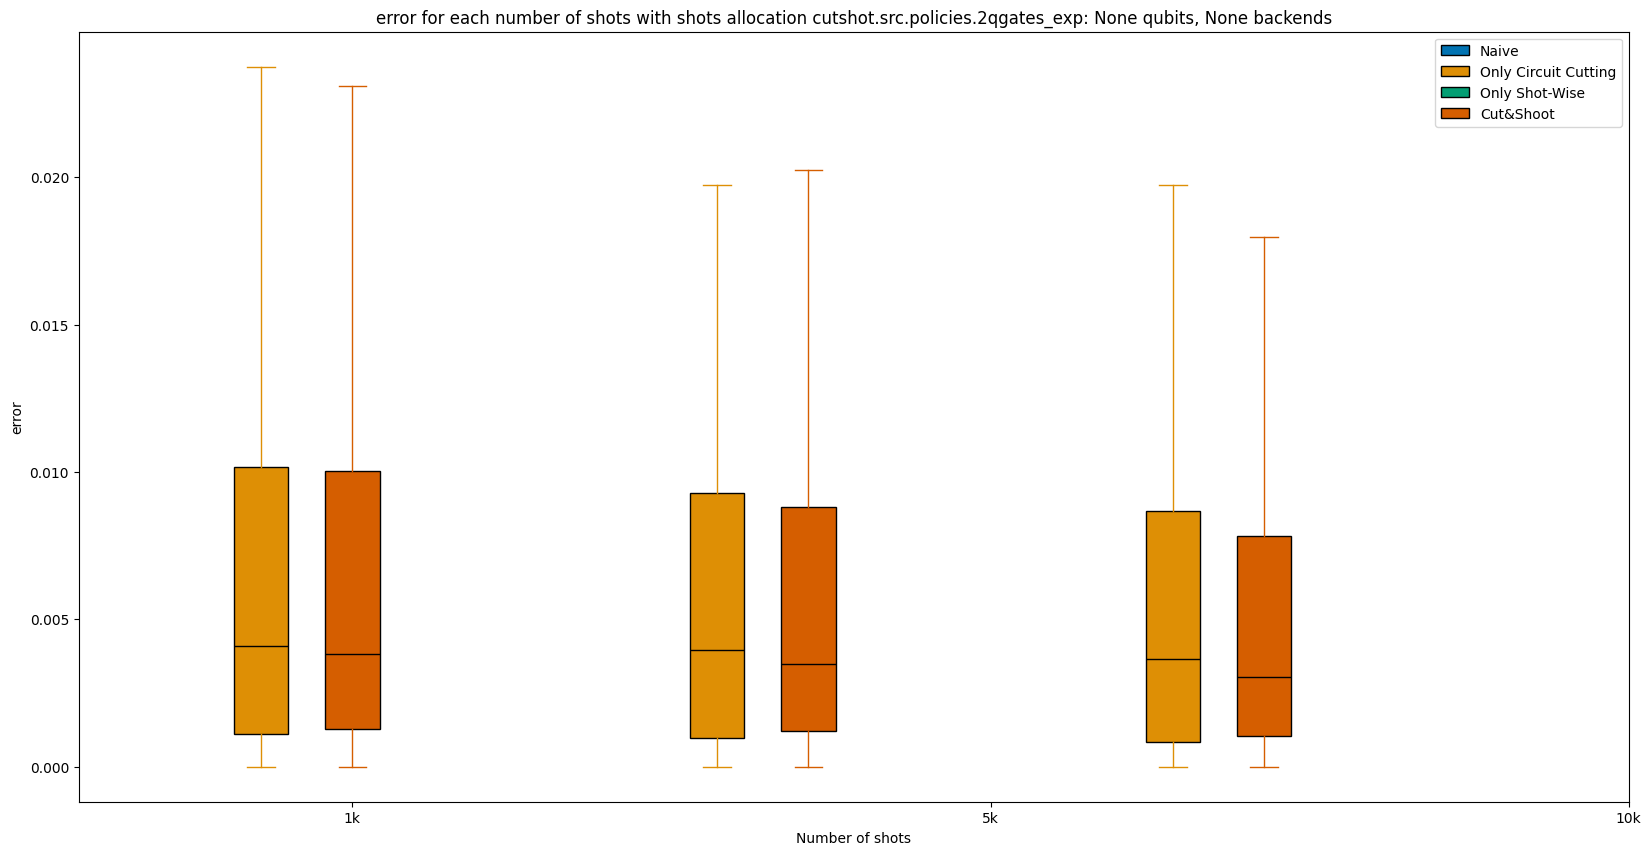

             circuit_id  qubits  \
121     n4_r2_k2_p1_s15      10   
125     n4_r2_k2_p1_s18      10   
127    n2_r2_k1_p1_s136       5   
130     n2_r2_k1_p1_s25       5   
133    n2_r2_k1_p1_s113       5   
...                 ...     ...   
40004   n4_r2_k2_p1_s24      10   
40009   n4_r2_k2_p1_s27      10   
40011  n2_r2_k1_p1_s127       5   
40012   n4_r2_k2_p1_s18      10   
40016  n2_r2_k1_p1_s127       5   

                                                backends  num_backends  \
121                          [ibm_aer/aer.fake_kawasaki]             1   
125                        [ibm_aer/aer.fake_sherbrooke]             1   
127                             [ibm_aer/aer.fake_cusco]             1   
130                             [ibm_aer/aer.fake_kyoto]             1   
133                             [ibm_aer/aer.fake_osaka]             1   
...                                                  ...           ...   
40004  [ibm_aer/aer.fake_kyoto, ibm_aer/aer.fake_cusc...     

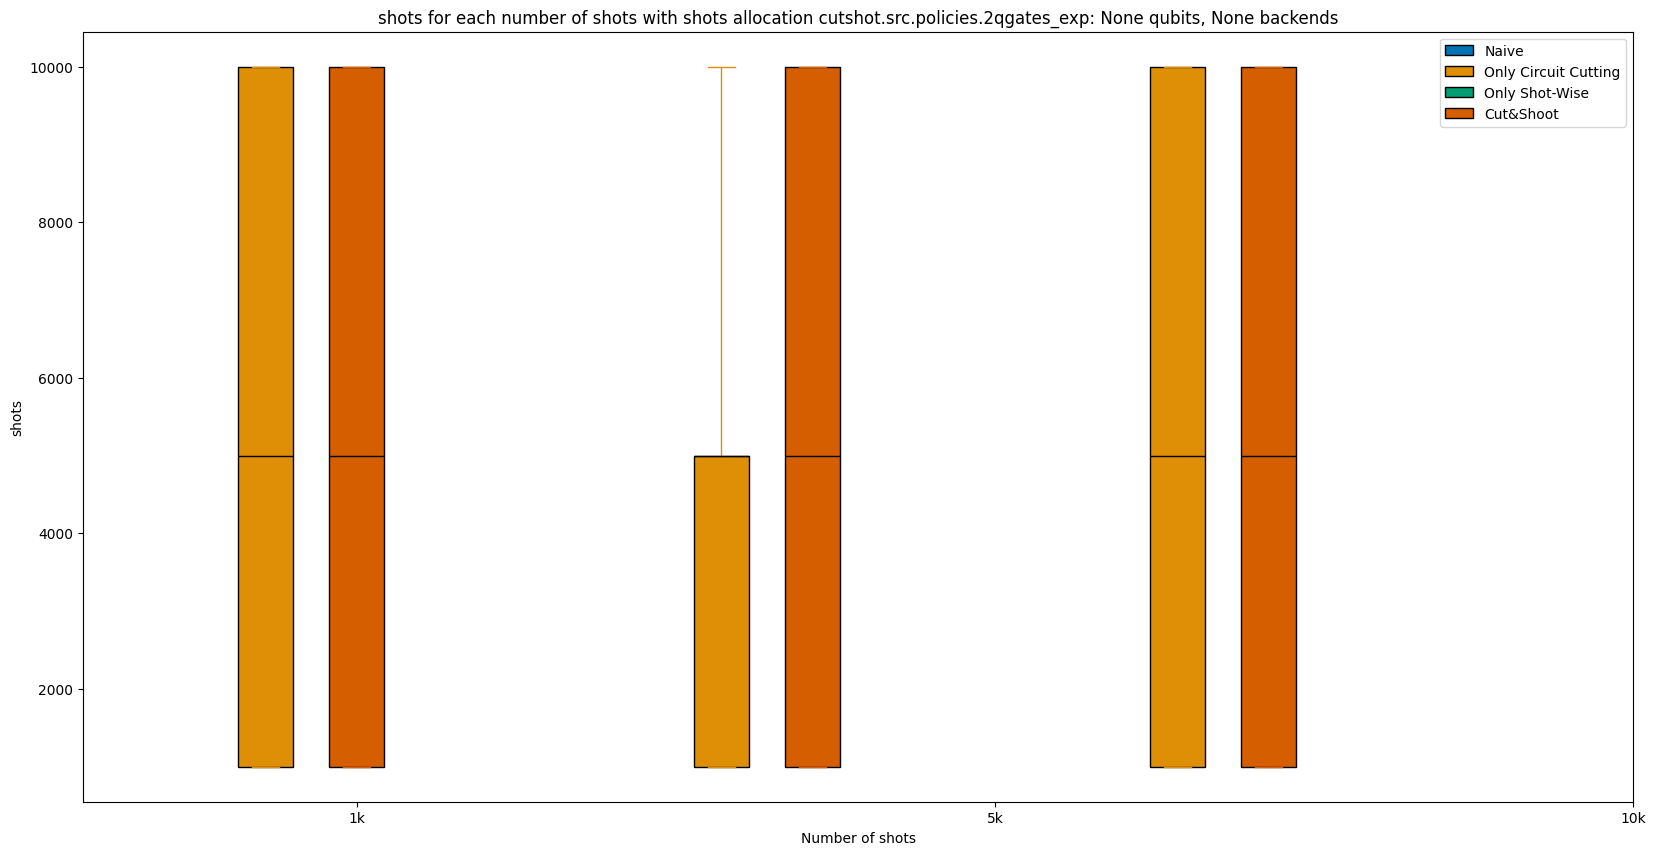

             circuit_id  qubits  \
40138   n2_r2_k1_p1_s25       5   
40139    n4_r3_k1_p1_s2      14   
40141   n4_r3_k1_p1_s22      14   
40144   n4_r2_k2_p1_s15      10   
40145  n2_r2_k1_p1_s113       5   
...                 ...     ...   
59132   n4_r2_k2_p1_s27      10   
59134   n4_r2_k2_p1_s24      10   
59137    n4_r3_k1_p1_s9      14   
59139  n2_r2_k1_p1_s149       5   
59142   n4_r2_k2_p1_s18      10   

                                                backends  num_backends  \
40138                          [ibm_aer/aer.fake_quebec]             1   
40139                      [ibm_aer/aer.fake_sherbrooke]             1   
40141                            [ibm_aer/aer.fake_kyiv]             1   
40144                           [ibm_aer/aer.fake_osaka]             1   
40145                           [ibm_aer/aer.fake_cusco]             1   
...                                                  ...           ...   
59132  [ibm_aer/aer.fake_osaka, ibm_aer/aer.fake_cusc...     

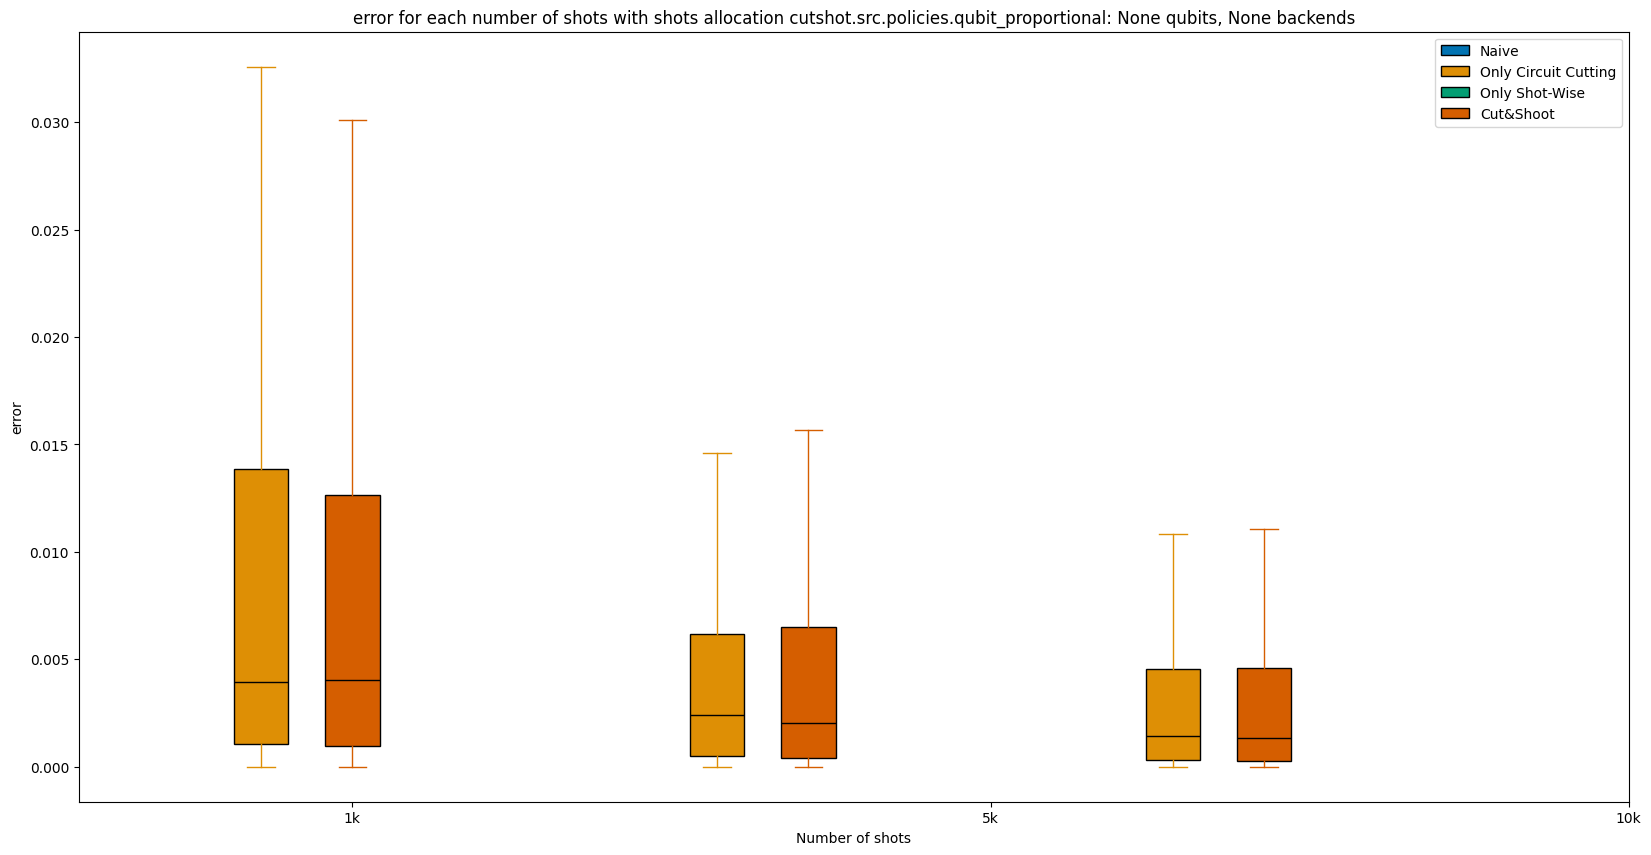

             circuit_id  qubits  \
40138   n2_r2_k1_p1_s25       5   
40139    n4_r3_k1_p1_s2      14   
40141   n4_r3_k1_p1_s22      14   
40144   n4_r2_k2_p1_s15      10   
40145  n2_r2_k1_p1_s113       5   
...                 ...     ...   
59132   n4_r2_k2_p1_s27      10   
59134   n4_r2_k2_p1_s24      10   
59137    n4_r3_k1_p1_s9      14   
59139  n2_r2_k1_p1_s149       5   
59142   n4_r2_k2_p1_s18      10   

                                                backends  num_backends  \
40138                          [ibm_aer/aer.fake_quebec]             1   
40139                      [ibm_aer/aer.fake_sherbrooke]             1   
40141                            [ibm_aer/aer.fake_kyiv]             1   
40144                           [ibm_aer/aer.fake_osaka]             1   
40145                           [ibm_aer/aer.fake_cusco]             1   
...                                                  ...           ...   
59132  [ibm_aer/aer.fake_osaka, ibm_aer/aer.fake_cusc...     

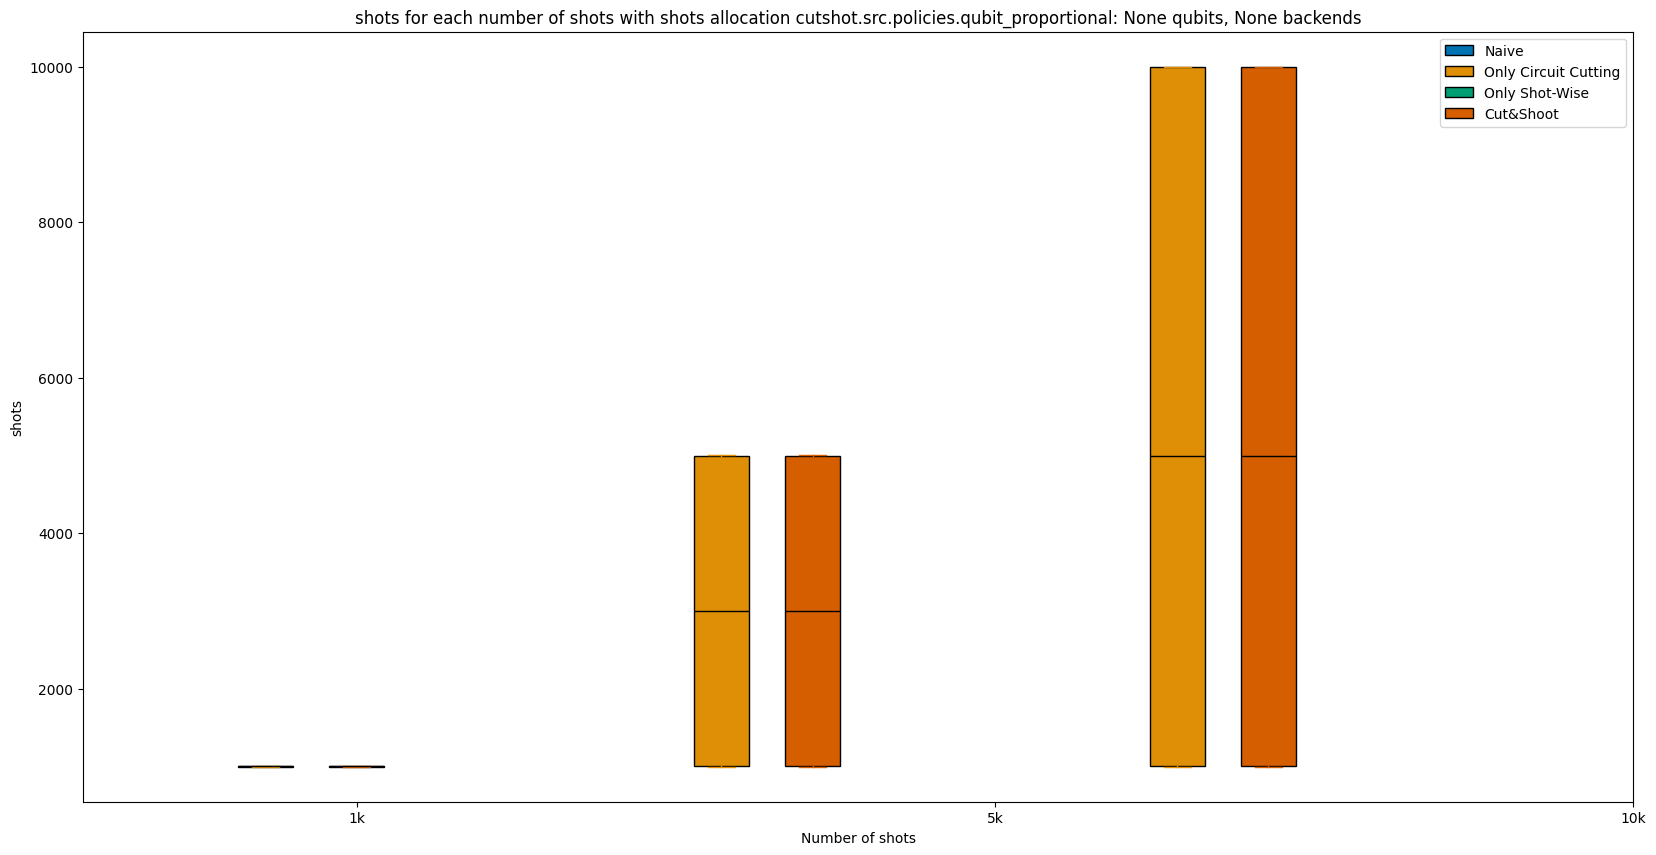

             circuit_id  qubits  \
40140  n2_r2_k1_p1_s149       5   
40142    n4_r3_k1_p1_s0      14   
40143   n2_r2_k1_p1_s25       5   
40151    n4_r3_k1_p1_s0      14   
40154    n4_r3_k1_p1_s9      14   
...                 ...     ...   
59131   n4_r2_k2_p1_s27      10   
59135   n4_r3_k1_p1_s22      14   
59138   n4_r3_k1_p1_s11      14   
59140   n4_r2_k2_p1_s27      10   
59141  n2_r2_k1_p1_s149       5   

                                                backends  num_backends  \
40140                        [ibm_aer/aer.fake_kawasaki]             1   
40142                            [ibm_aer/aer.fake_kyiv]             1   
40143                        [ibm_aer/aer.fake_kawasaki]             1   
40151                        [ibm_aer/aer.fake_brisbane]             1   
40154                        [ibm_aer/aer.fake_brisbane]             1   
...                                                  ...           ...   
59131  [ibm_aer/aer.fake_brisbane, ibm_aer/aer.fake_c...     

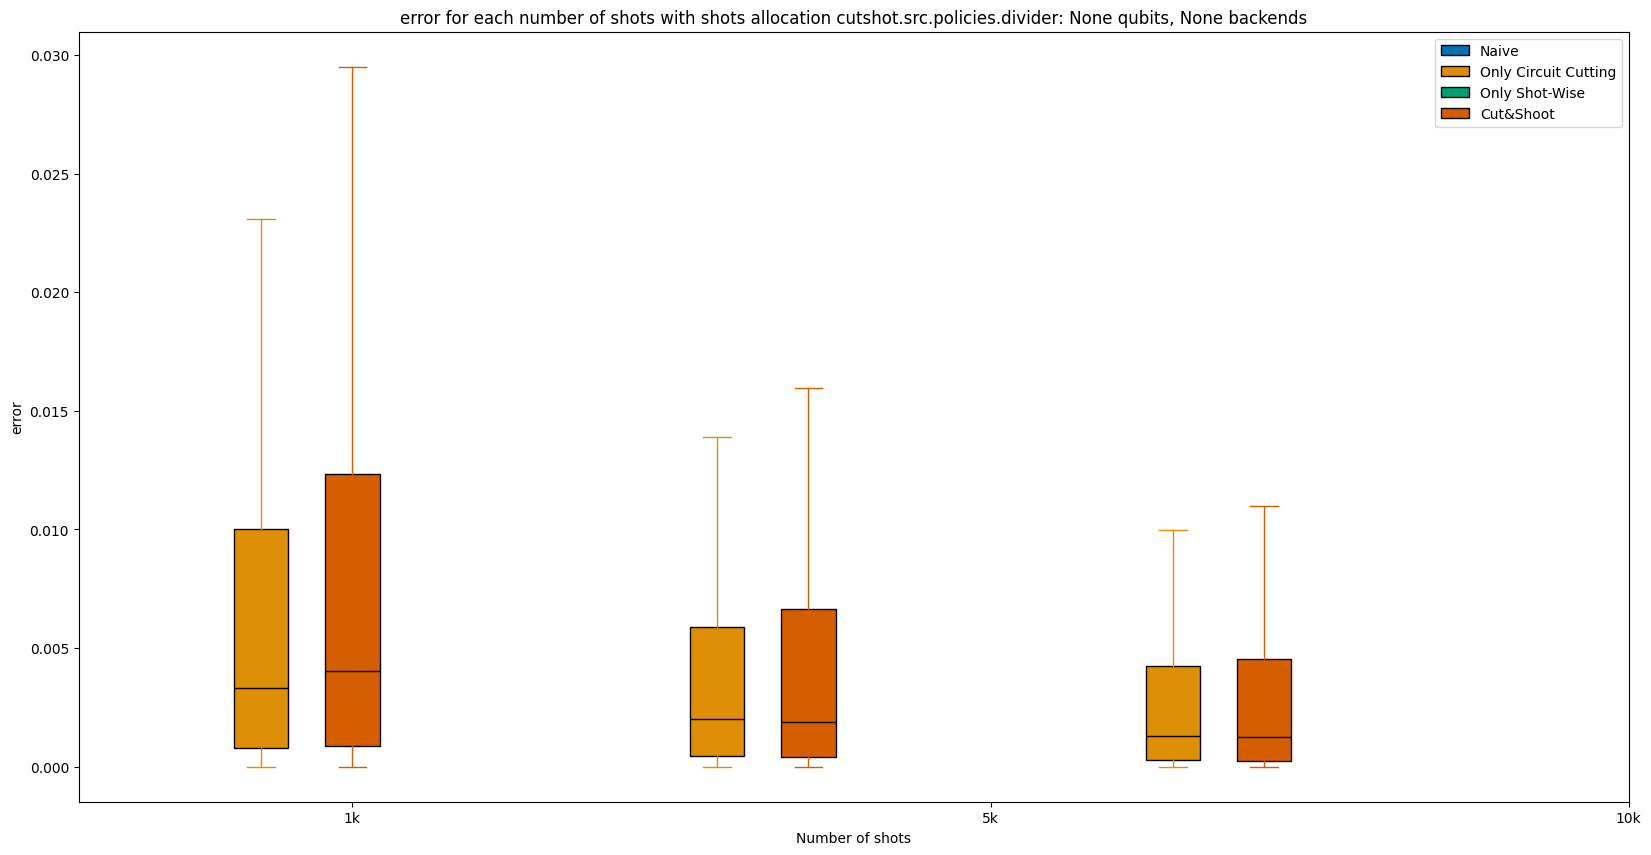

             circuit_id  qubits  \
40140  n2_r2_k1_p1_s149       5   
40142    n4_r3_k1_p1_s0      14   
40143   n2_r2_k1_p1_s25       5   
40151    n4_r3_k1_p1_s0      14   
40154    n4_r3_k1_p1_s9      14   
...                 ...     ...   
59131   n4_r2_k2_p1_s27      10   
59135   n4_r3_k1_p1_s22      14   
59138   n4_r3_k1_p1_s11      14   
59140   n4_r2_k2_p1_s27      10   
59141  n2_r2_k1_p1_s149       5   

                                                backends  num_backends  \
40140                        [ibm_aer/aer.fake_kawasaki]             1   
40142                            [ibm_aer/aer.fake_kyiv]             1   
40143                        [ibm_aer/aer.fake_kawasaki]             1   
40151                        [ibm_aer/aer.fake_brisbane]             1   
40154                        [ibm_aer/aer.fake_brisbane]             1   
...                                                  ...           ...   
59131  [ibm_aer/aer.fake_brisbane, ibm_aer/aer.fake_c...     

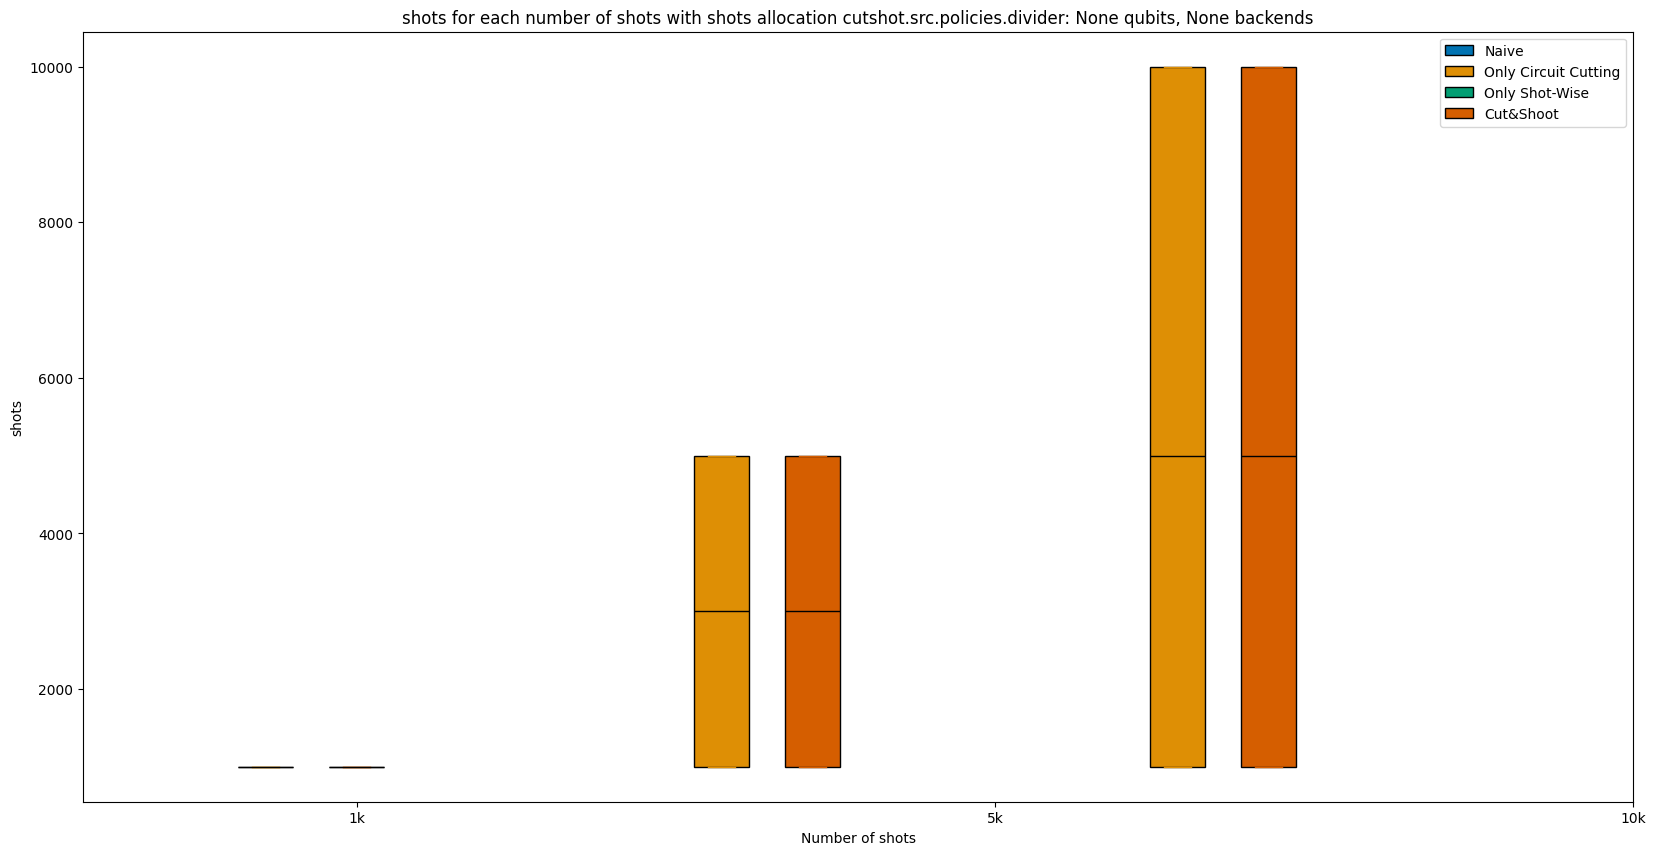

             circuit_id  qubits  \
40146   n4_r2_k2_p1_s27      10   
40147  n2_r2_k1_p1_s149       5   
40150   n4_r3_k1_p1_s11      14   
40159  n2_r2_k1_p1_s149       5   
40179    n4_r3_k1_p1_s2      14   
...                 ...     ...   
59116   n4_r2_k2_p1_s15      10   
59123   n4_r2_k2_p1_s24      10   
59124    n4_r3_k1_p1_s0      14   
59125    n4_r3_k1_p1_s9      14   
59136   n4_r3_k1_p1_s11      14   

                                                backends  num_backends  \
40146                      [ibm_aer/aer.fake_sherbrooke]             1   
40147                      [ibm_aer/aer.fake_sherbrooke]             1   
40150                      [ibm_aer/aer.fake_sherbrooke]             1   
40159                          [ibm_aer/aer.fake_quebec]             1   
40179                      [ibm_aer/aer.fake_sherbrooke]             1   
...                                                  ...           ...   
59116  [ibm_aer/aer.fake_brisbane, ibm_aer/aer.fake_k...     

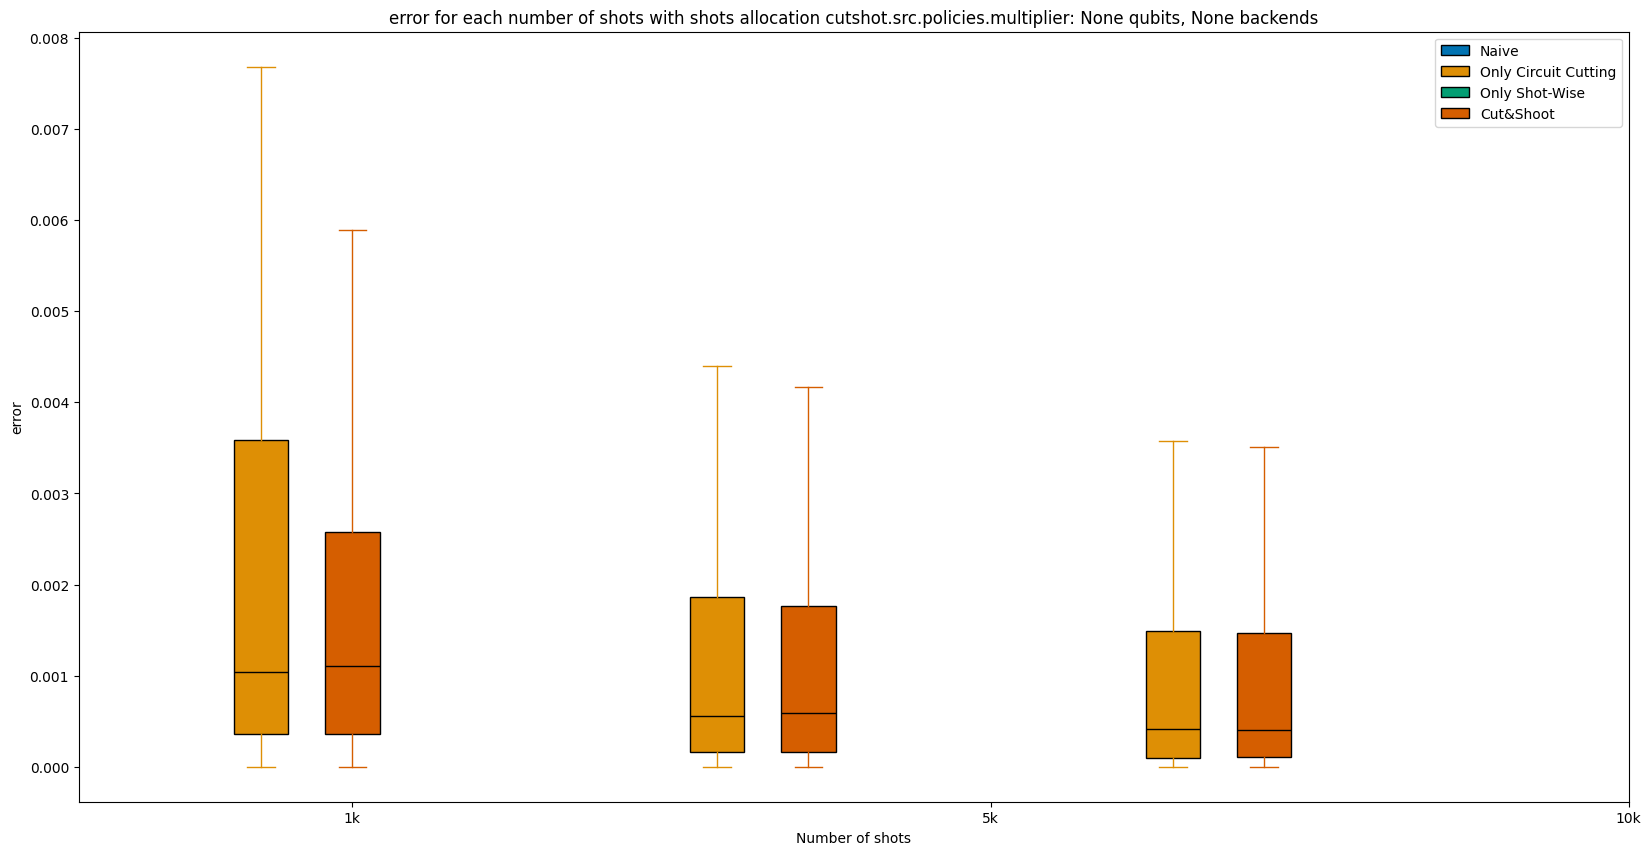

             circuit_id  qubits  \
40146   n4_r2_k2_p1_s27      10   
40147  n2_r2_k1_p1_s149       5   
40150   n4_r3_k1_p1_s11      14   
40159  n2_r2_k1_p1_s149       5   
40179    n4_r3_k1_p1_s2      14   
...                 ...     ...   
59116   n4_r2_k2_p1_s15      10   
59123   n4_r2_k2_p1_s24      10   
59124    n4_r3_k1_p1_s0      14   
59125    n4_r3_k1_p1_s9      14   
59136   n4_r3_k1_p1_s11      14   

                                                backends  num_backends  \
40146                      [ibm_aer/aer.fake_sherbrooke]             1   
40147                      [ibm_aer/aer.fake_sherbrooke]             1   
40150                      [ibm_aer/aer.fake_sherbrooke]             1   
40159                          [ibm_aer/aer.fake_quebec]             1   
40179                      [ibm_aer/aer.fake_sherbrooke]             1   
...                                                  ...           ...   
59116  [ibm_aer/aer.fake_brisbane, ibm_aer/aer.fake_k...     

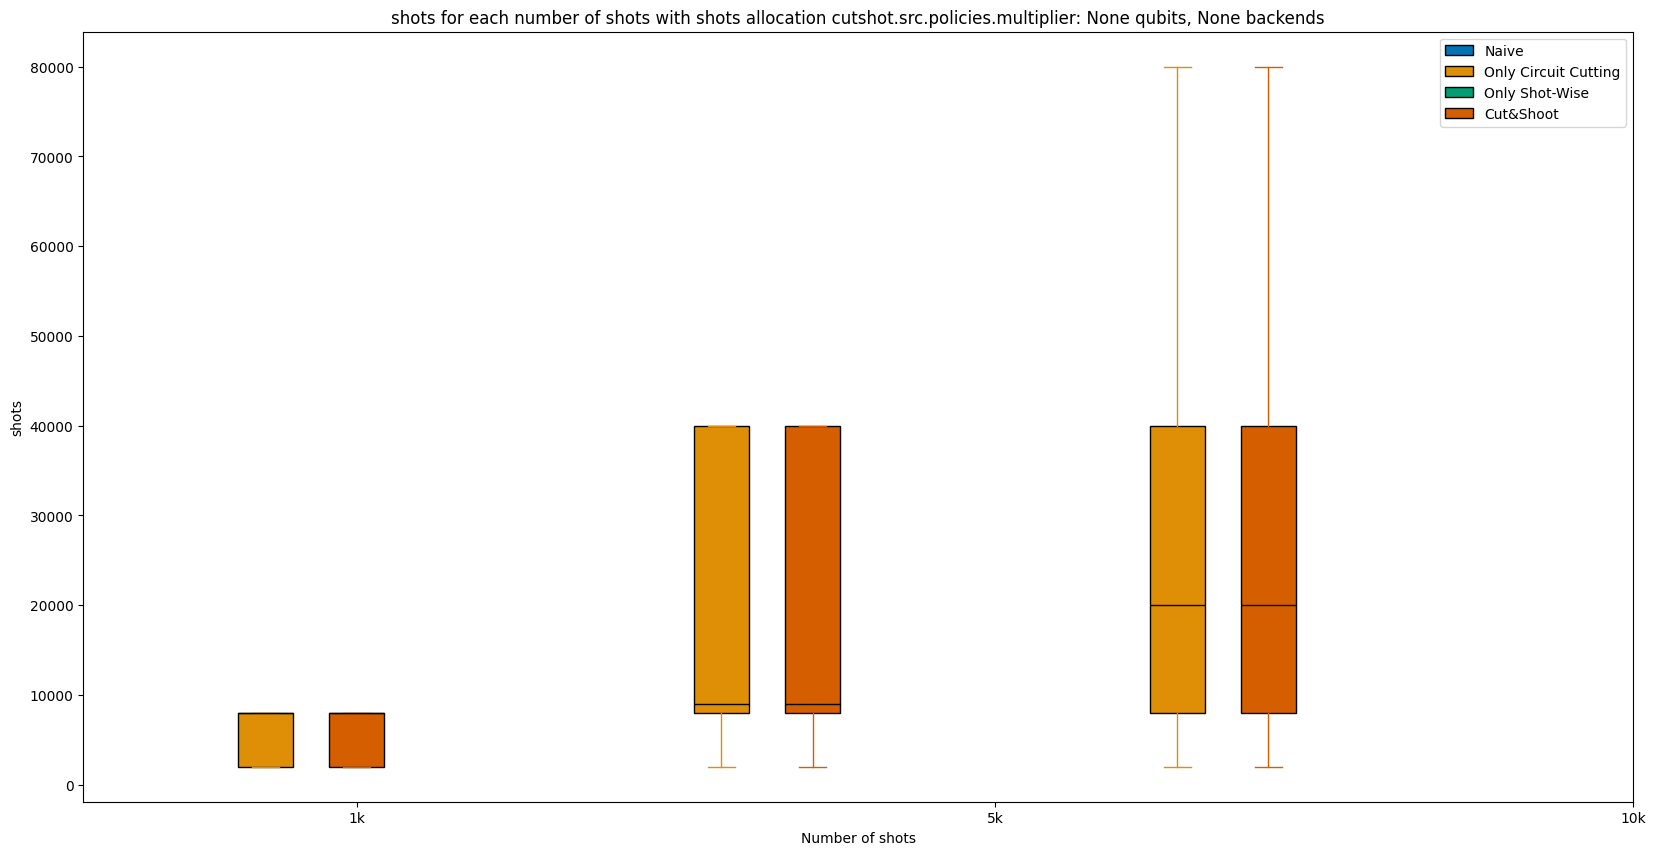

             circuit_id  qubits  \
40153   n2_r2_k1_p1_s25       5   
40155  n2_r2_k1_p1_s136       5   
40156  n2_r2_k1_p1_s127       5   
40165  n2_r2_k1_p1_s149       5   
40166    n4_r3_k1_p1_s9      14   
...                 ...     ...   
59112   n4_r2_k2_p1_s24      10   
59121   n4_r2_k2_p1_s18      10   
59127    n4_r3_k1_p1_s0      14   
59128   n4_r2_k2_p1_s27      10   
59133   n4_r3_k1_p1_s22      14   

                                                backends  num_backends  \
40153                           [ibm_aer/aer.fake_osaka]             1   
40155                      [ibm_aer/aer.fake_sherbrooke]             1   
40156                        [ibm_aer/aer.fake_brisbane]             1   
40165                      [ibm_aer/aer.fake_sherbrooke]             1   
40166                        [ibm_aer/aer.fake_brisbane]             1   
...                                                  ...           ...   
59112  [ibm_aer/aer.fake_sherbrooke, ibm_aer/aer.fake...     

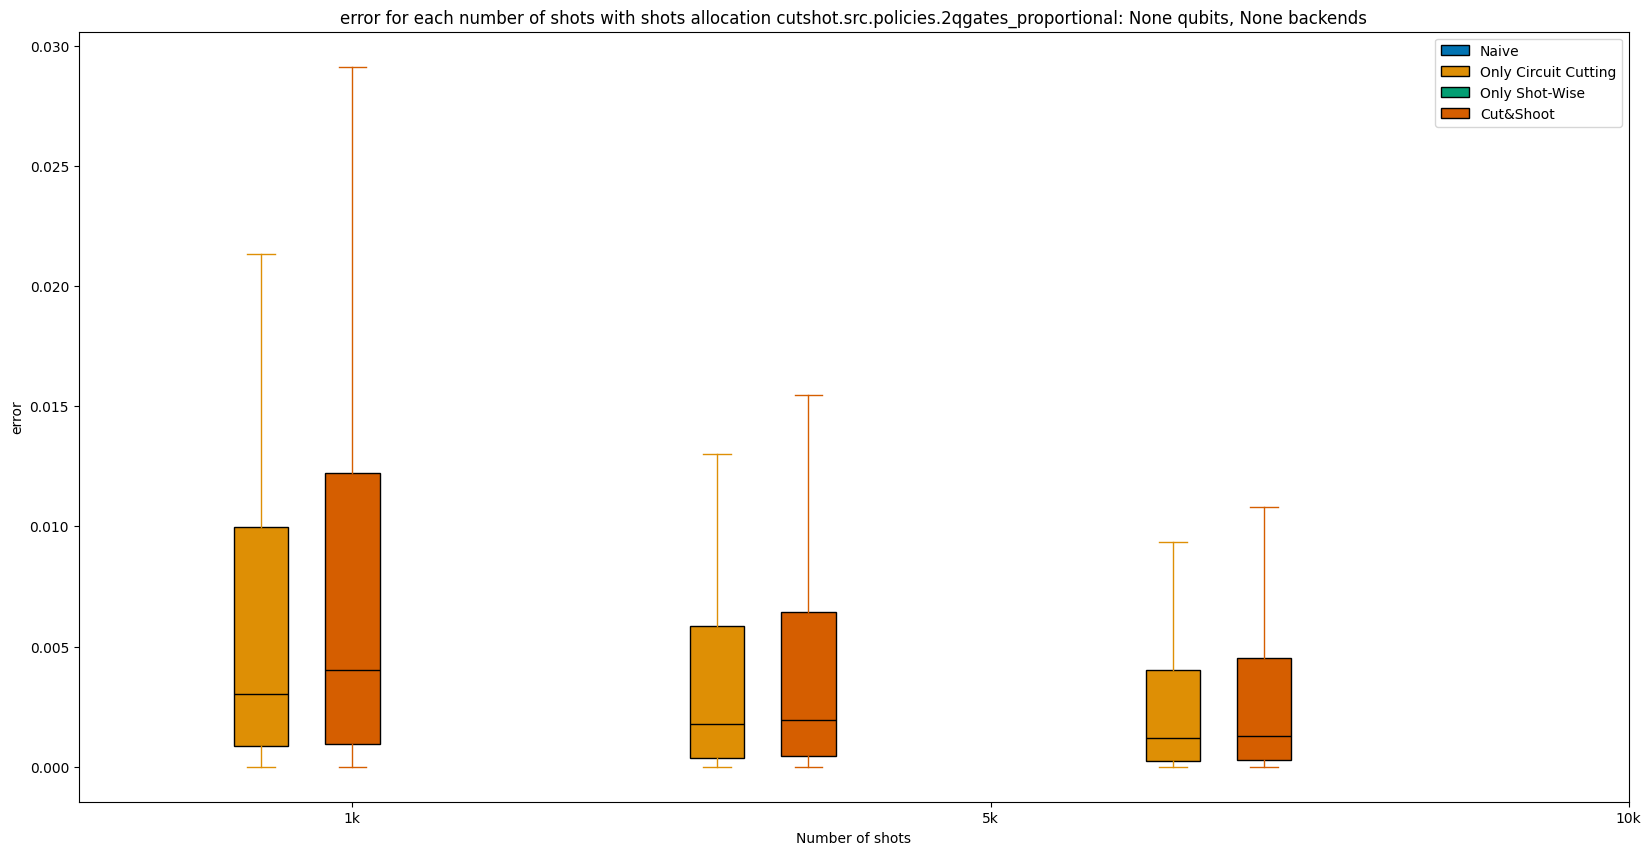

             circuit_id  qubits  \
40153   n2_r2_k1_p1_s25       5   
40155  n2_r2_k1_p1_s136       5   
40156  n2_r2_k1_p1_s127       5   
40165  n2_r2_k1_p1_s149       5   
40166    n4_r3_k1_p1_s9      14   
...                 ...     ...   
59112   n4_r2_k2_p1_s24      10   
59121   n4_r2_k2_p1_s18      10   
59127    n4_r3_k1_p1_s0      14   
59128   n4_r2_k2_p1_s27      10   
59133   n4_r3_k1_p1_s22      14   

                                                backends  num_backends  \
40153                           [ibm_aer/aer.fake_osaka]             1   
40155                      [ibm_aer/aer.fake_sherbrooke]             1   
40156                        [ibm_aer/aer.fake_brisbane]             1   
40165                      [ibm_aer/aer.fake_sherbrooke]             1   
40166                        [ibm_aer/aer.fake_brisbane]             1   
...                                                  ...           ...   
59112  [ibm_aer/aer.fake_sherbrooke, ibm_aer/aer.fake...     

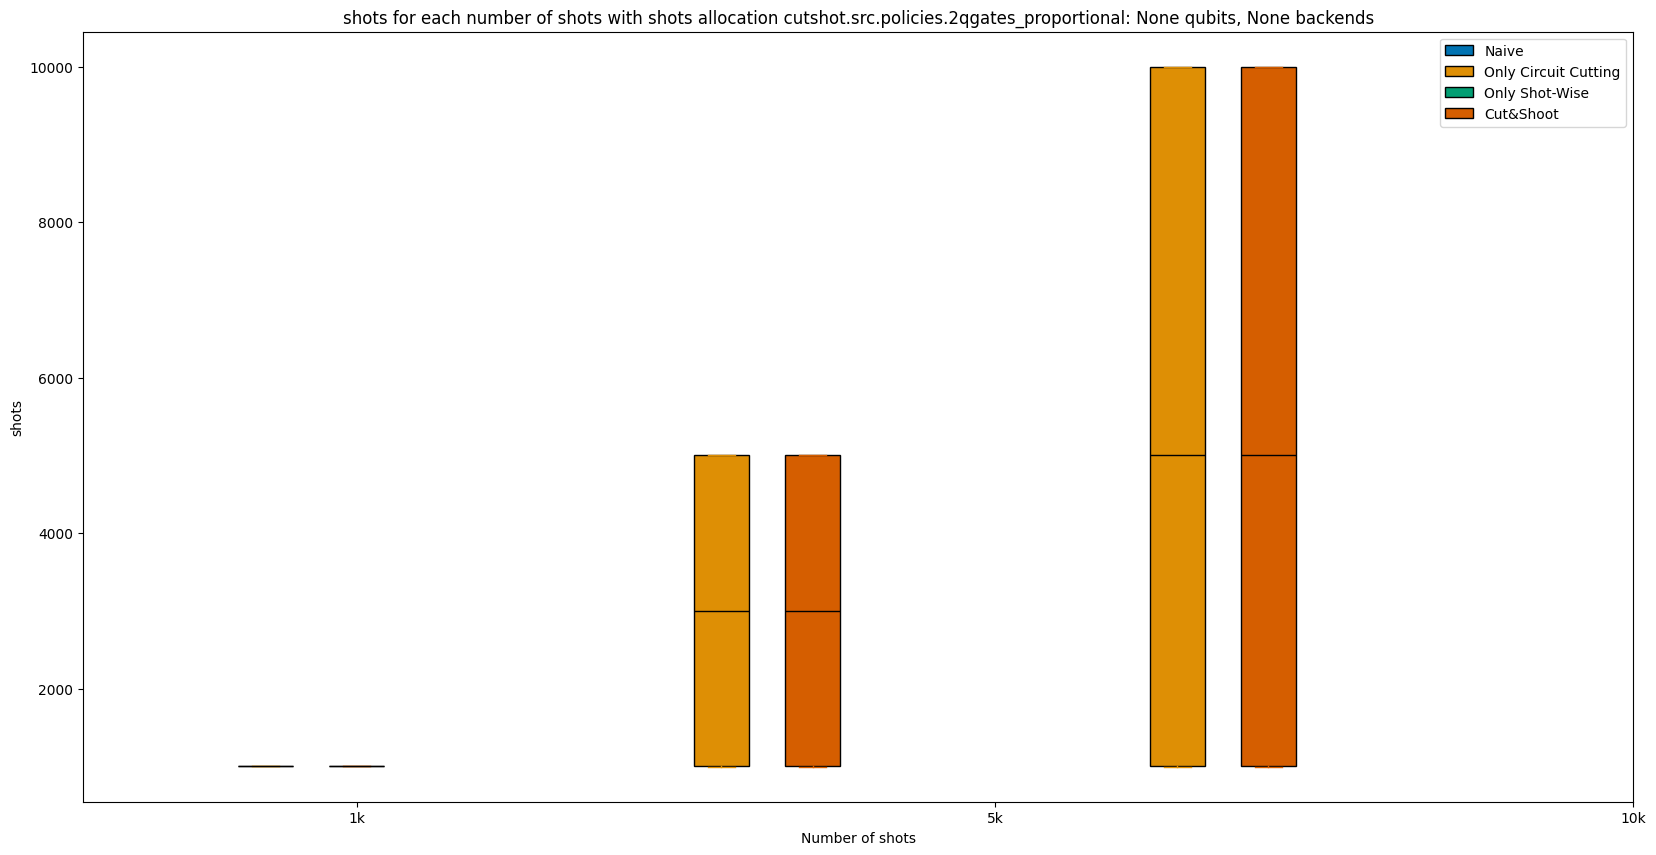

In [10]:
# for each number of backends, plot the error as cadlesticks, one for each strategy

print(exp_data_df["shots_allocation"].unique())

for sa in exp_data_df["shots_allocation"].unique().copy():
    if sa is None:
        continue
    for attr in ["error", "shots"]:
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        pos = 0
        for exp_data_df, legend_name in zip(exp_data_dfs, exp_legend):
            if sa not in exp_data_df["shots_allocation"].unique() or exp_data_df[exp_data_df["shots_allocation"] == sa].empty:
                print(f"No data for {legend_name} {sa}")
                continue
            else:
                print(exp_data_df[exp_data_df["shots_allocation"] == sa])
            
            for strategy in exp_data_df["strategy"].unique():
                data_strat = exp_data_df[(exp_data_df["strategy"] == strategy) & (exp_data_df["shots_allocation"] == sa)]
                
                if qubit_size:
                    data_strat = data_strat[data_strat["qubits"] == qubit_size]
                if backend_size and strategy not in ["vanilla", "cc"]:
                    data_strat = data_strat[data_strat["num_backends"] == backend_size]
                    
                if (len(data_strat) == 0 or data_strat.empty):
                    # print(f"No data for {legend_name} {strategy} {sa}")
                    continue
                else:
                    if "exp" in sa:
                        print(f"Data for {legend_name} {strategy} {sa}")
                
                color = colors[strategy]
                ax.boxplot(data_strat[attr], positions=[pos], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
                pos += 0.25

            pos += 0.75

        ax.set_xlabel("Number of shots")
        ax.set_ylabel(attr)
        ax.set_title(f"{attr} for each number of shots with shots allocation {sa}: {qubit_size} qubits, {backend_size} backends")
        ax.set_xticks(np.arange(len(exp_data_dfs)) * 1.75 + 0.25)
        ax.set_xticklabels(exp_legend)
        ax.legend([plt.Rectangle((0,0),1,1,fc=colors[strategy], ec="black") for strategy in exp_data_df["strategy"].unique()], [legend[strategy] for strategy in exp_data_df["strategy"].unique()])
        plt.savefig(plots_dir + f"{attr}_per_strategy_{sa}_{qubit_size}q_{backend_size}b.png")
        plt.show()





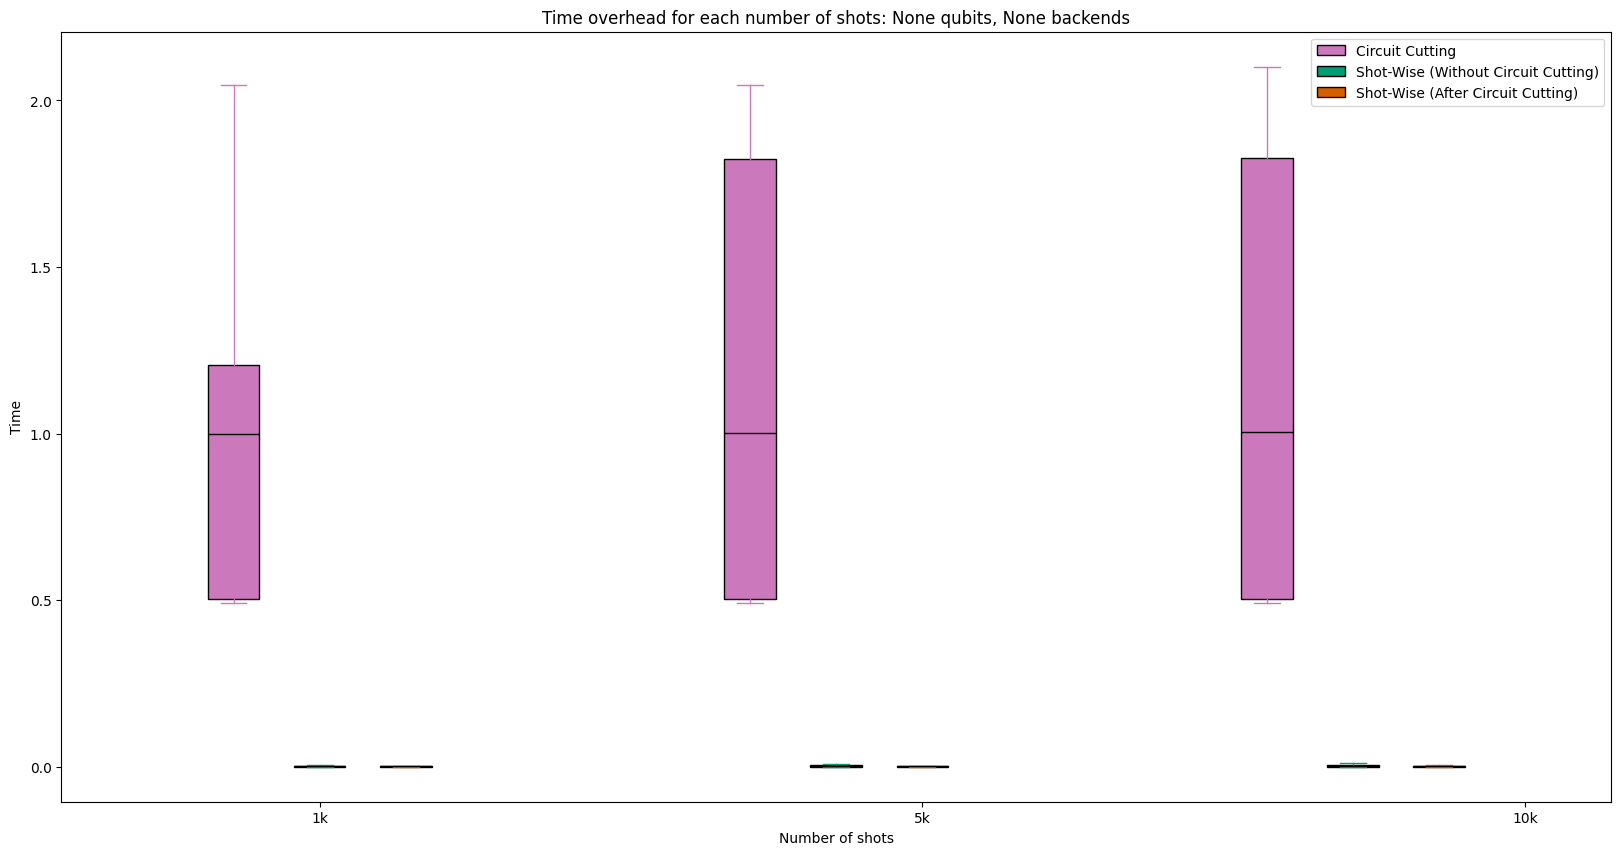

In [11]:

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

strategies = ["cc_all", "sw_without", "sw_after"]
offset = 0
for exp_data_df in exp_data_dfs:
    data = exp_data_df.copy()
    
    if qubit_size:
        data = data[data["qubits"] == qubit_size]
    if backend_size:
        data = data[data["num_backends"] == backend_size]
    
    # circuit cutting overhead is not nan
    circuit_cutting_overhead = data[[not np.isnan(x) for x in data["circuit_cutting_overhead"]]]
    
    shot_wise_overhead = data[[not np.isnan(x) for x in data["shot_wise_overhead"]]]
    shot_wise_overhead_with_cc = shot_wise_overhead[[not np.isnan(x) for x in shot_wise_overhead["circuit_cutting_overhead"]]]
    shot_wise_overhead_without_cc = shot_wise_overhead[[np.isnan(x) for x in shot_wise_overhead["circuit_cutting_overhead"]]]
    
    color = colors["cc_all"]
    ax.boxplot(circuit_cutting_overhead["circuit_cutting_overhead"], positions=[offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
    offset += 0.25
        
    if not shot_wise_overhead_without_cc.empty:
        color = colors["sw_without"]
        ax.boxplot(shot_wise_overhead_without_cc["shot_wise_overhead"], positions=[offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        offset += 0.25
        
    if not shot_wise_overhead_with_cc.empty:
        color = colors["sw_after"]
        ax.boxplot(shot_wise_overhead_with_cc["shot_wise_overhead"], positions=[offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        offset += 0.25
        
    offset += 0.75
        
    
ax.set_xlabel("Number of shots")
ax.set_ylabel("Time")
ax.set_title(f"Time overhead for each number of shots: {qubit_size} qubits, {backend_size} backends")
ax.set_xticks(np.arange(len(exp_data_dfs)) * 1.75 + 0.25)
ax.set_xticklabels(exp_legend)
ax.legend([plt.Rectangle((0,0),1,1,fc=colors[strategy], ec="black") for strategy in strategies], [legend[strategy] for strategy in strategies])


plt.savefig(plots_dir + f"time_overhead_full_{qubit_size}q_{backend_size}b.png")
plt.show()

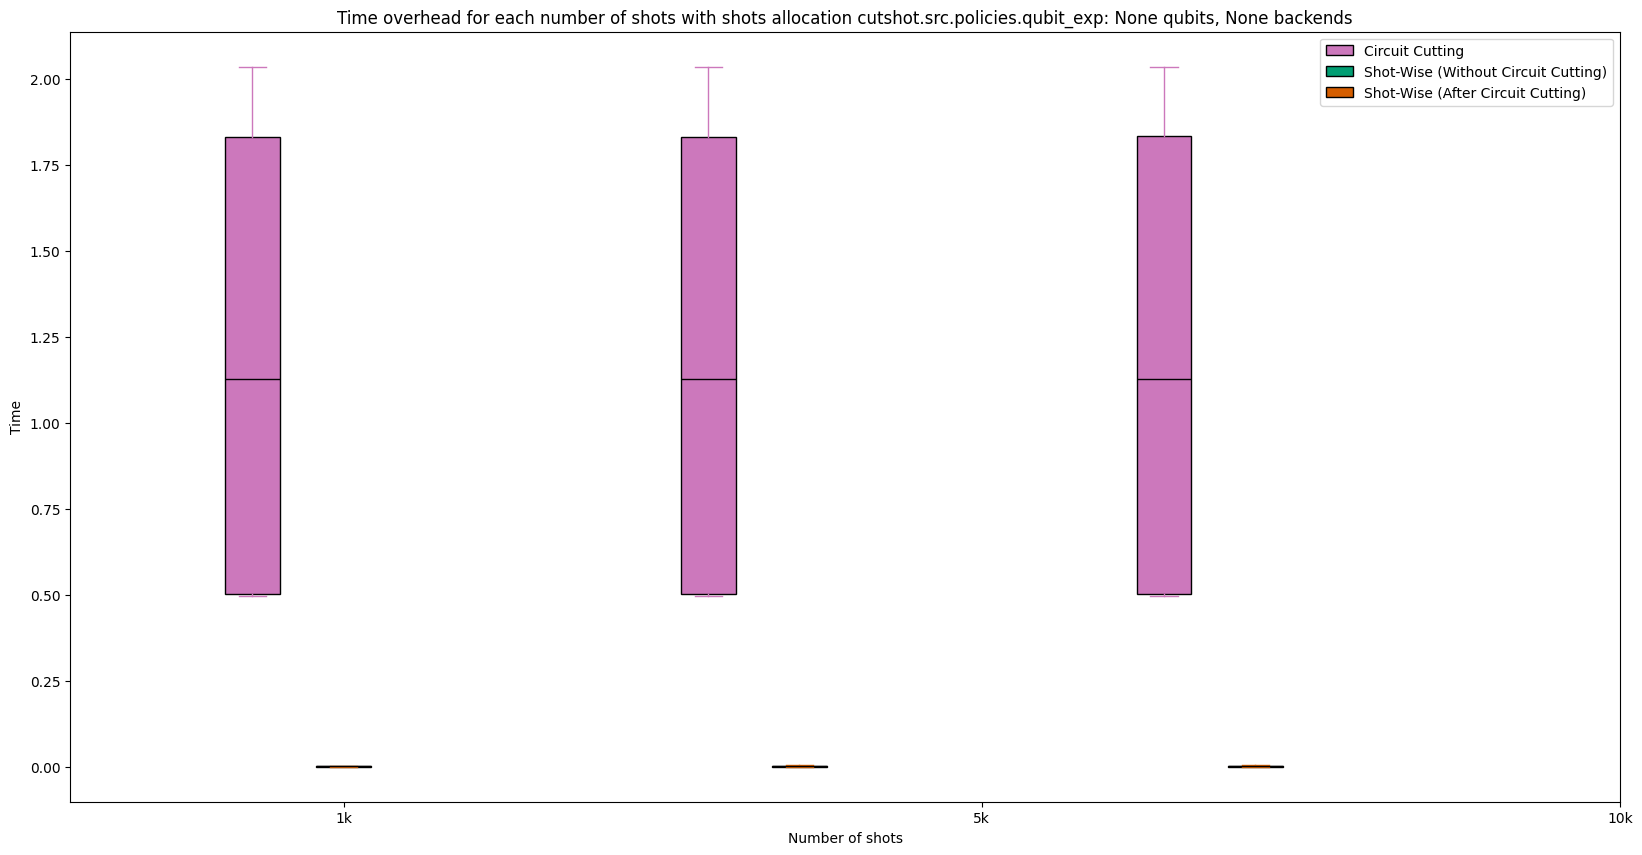

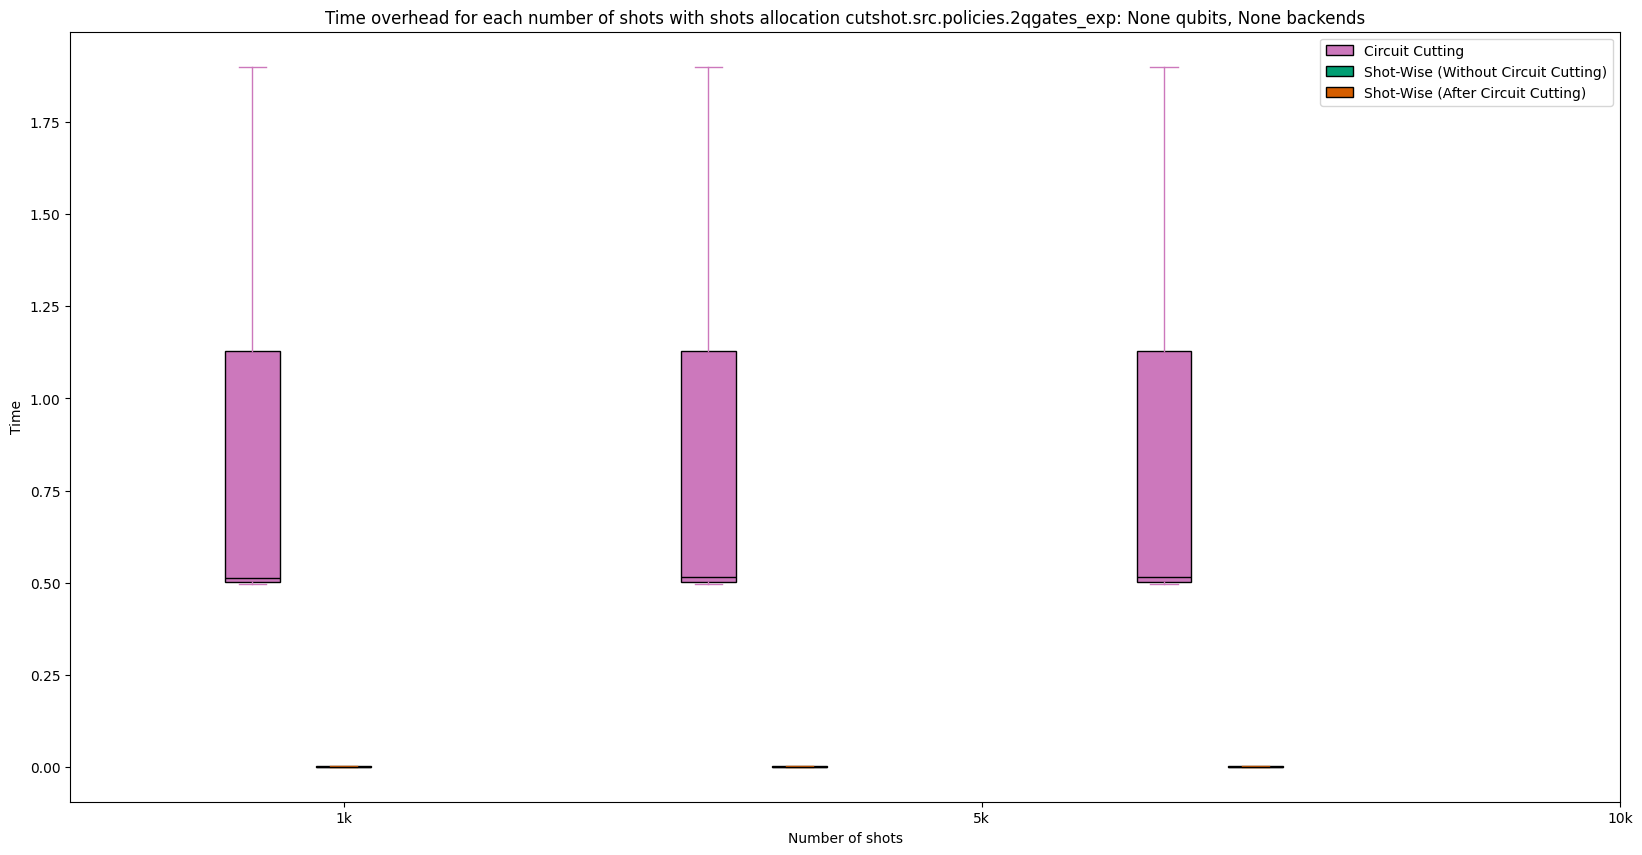

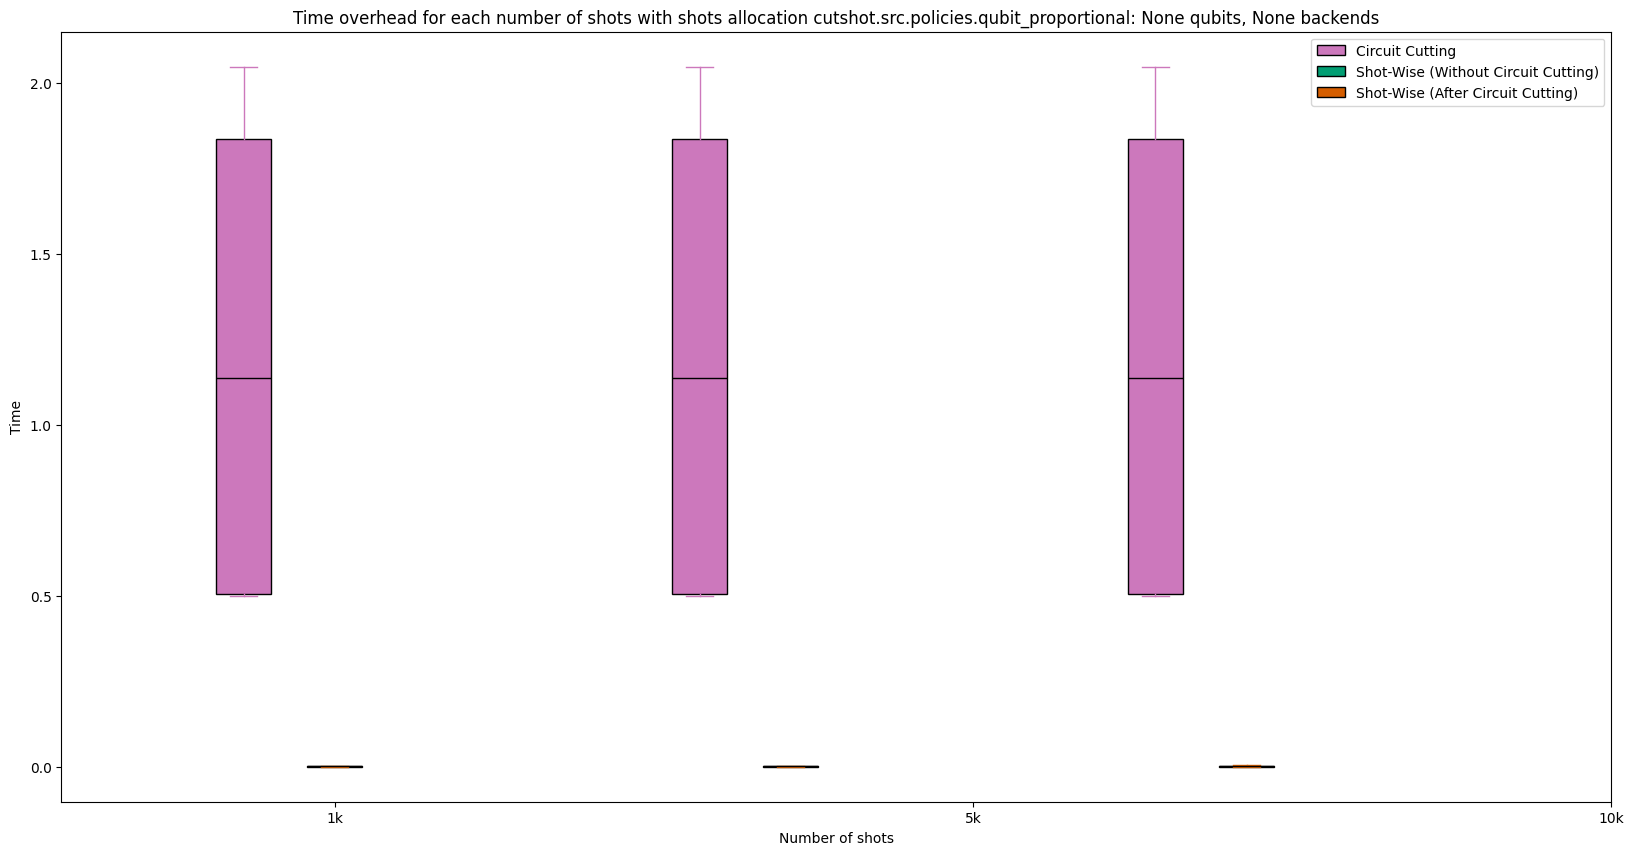

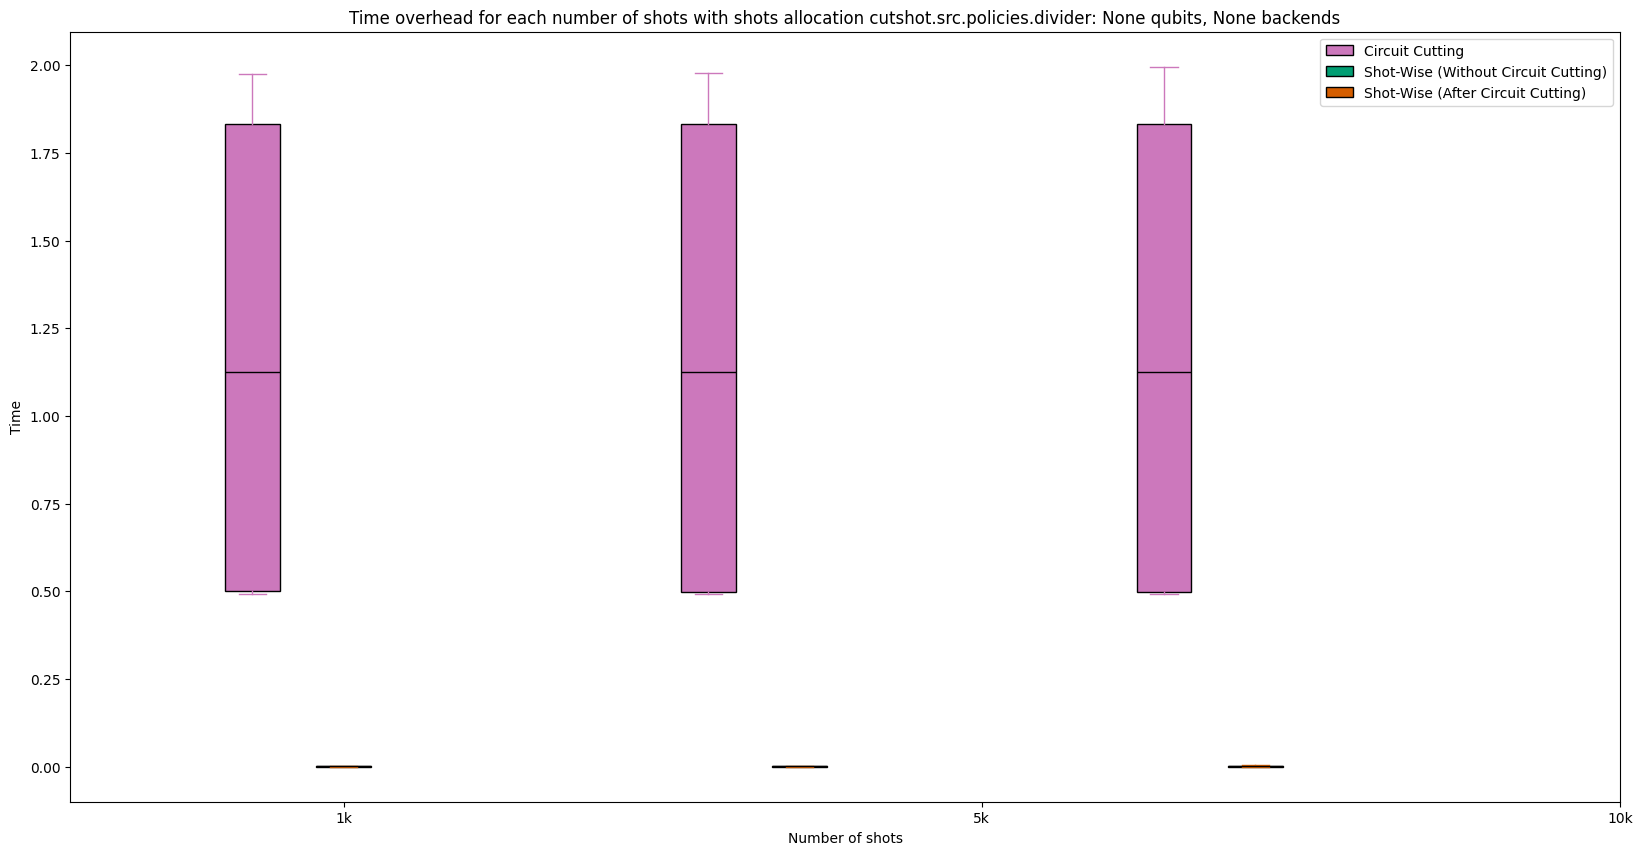

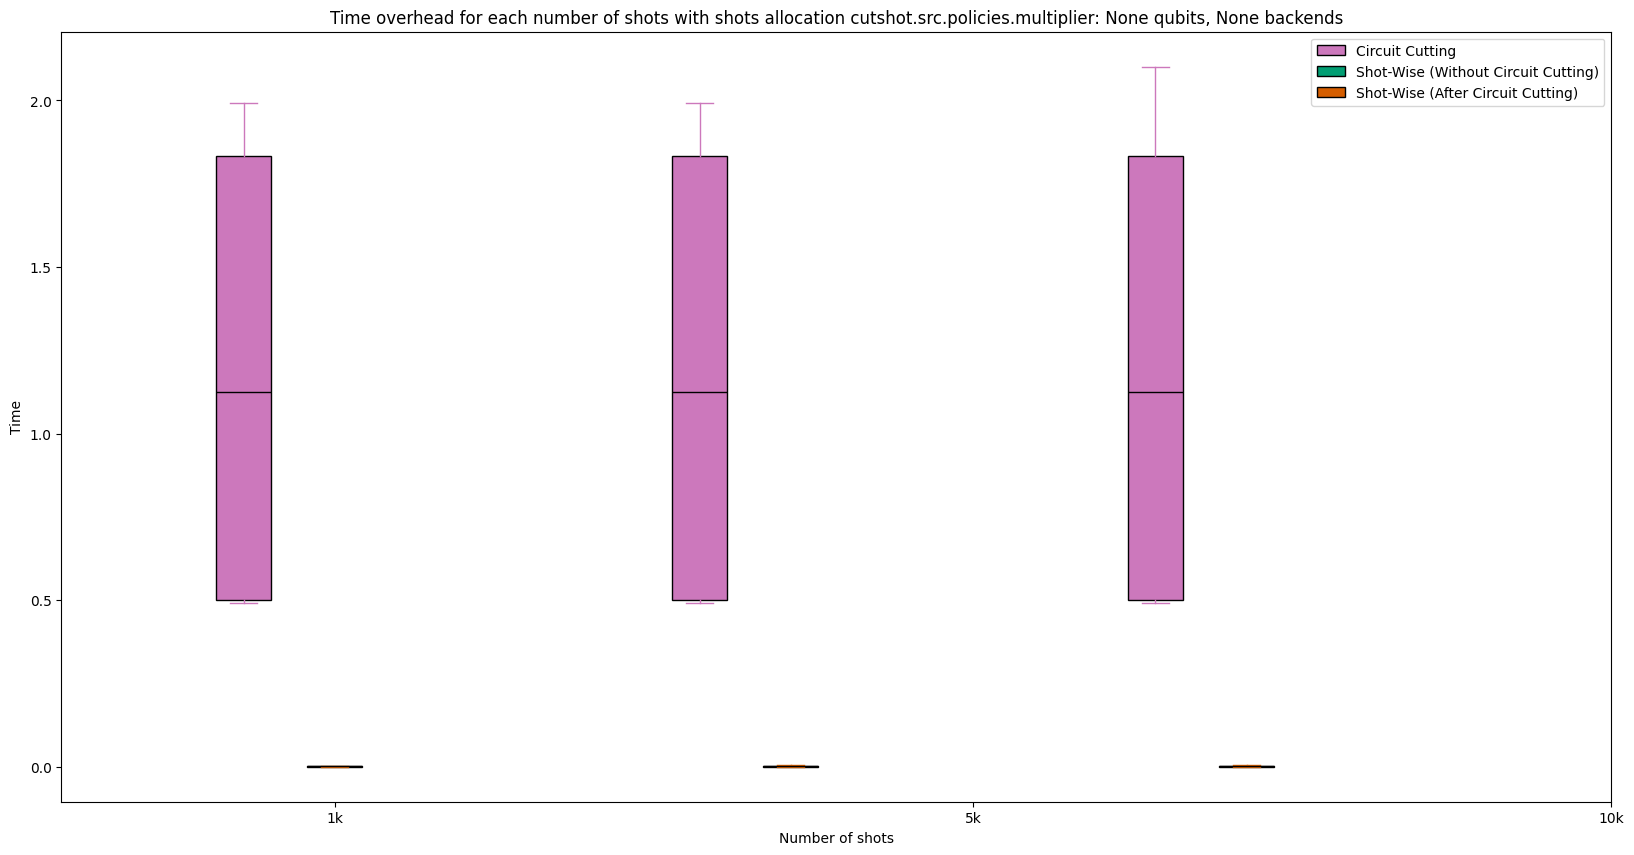

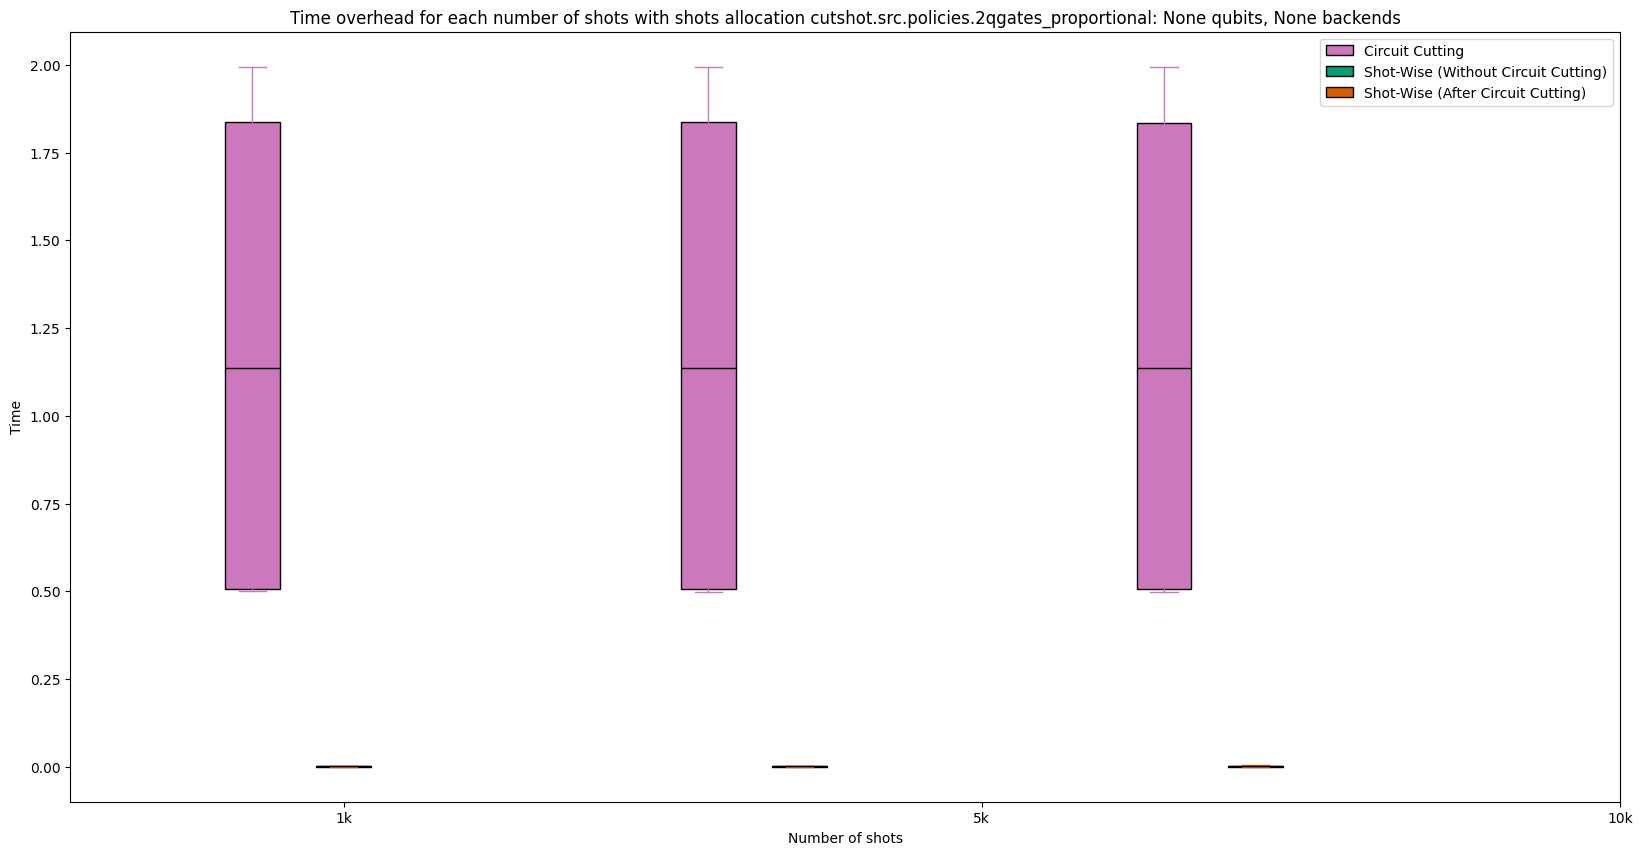

In [12]:
for sa in exp_data_df["shots_allocation"].unique():
    if sa is None:
        continue
    
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)

    strategies = ["cc_all", "sw_without", "sw_after"]

    offset = 0
    for exp_data_df in exp_data_dfs:
        data = exp_data_df[(exp_data_df["shots_allocation"] == sa)]
        
        if qubit_size:
            data = data[data["qubits"] == qubit_size]
        if backend_size:
            data = data[data["num_backends"] == backend_size]
        
        # circuit cutting overhead is not nan
        circuit_cutting_overhead = data[[not np.isnan(x) for x in data["circuit_cutting_overhead"]]]
        
        shot_wise_overhead = data[[not np.isnan(x) for x in data["shot_wise_overhead"]]]
        shot_wise_overhead_with_cc = shot_wise_overhead[[not np.isnan(x) for x in shot_wise_overhead["circuit_cutting_overhead"]]]
        shot_wise_overhead_without_cc = shot_wise_overhead[[np.isnan(x) for x in shot_wise_overhead["circuit_cutting_overhead"]]]
        
        color = colors["cc_all"]
        ax.boxplot(circuit_cutting_overhead["circuit_cutting_overhead"], positions=[offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        offset += 0.25
            
        if not shot_wise_overhead_without_cc.empty:
            color = colors["sw_without"]
            ax.boxplot(shot_wise_overhead_without_cc["shot_wise_overhead"], positions=[offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
            offset += 0.25
            
        if not shot_wise_overhead_with_cc.empty:
            color = colors["sw_after"]
            ax.boxplot(shot_wise_overhead_with_cc["shot_wise_overhead"], positions=[offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
            offset += 0.25
            
        offset += 0.75
            
        
    ax.set_xlabel("Number of shots")
    ax.set_ylabel("Time")
    ax.set_title(f"Time overhead for each number of shots with shots allocation {sa}: {qubit_size} qubits, {backend_size} backends")
    ax.set_xticks(np.arange(len(exp_data_dfs)) * 1.75 + 0.25)
    ax.set_xticklabels(exp_legend)
    ax.legend([plt.Rectangle((0,0),1,1,fc=colors[strategy], ec="black") for strategy in strategies], [legend[strategy] for strategy in strategies])
    
    plt.savefig(plots_dir + f"time_overhead_per_strategy_{sa}_{qubit_size}q_{backend_size}b.png")
    plt.show()

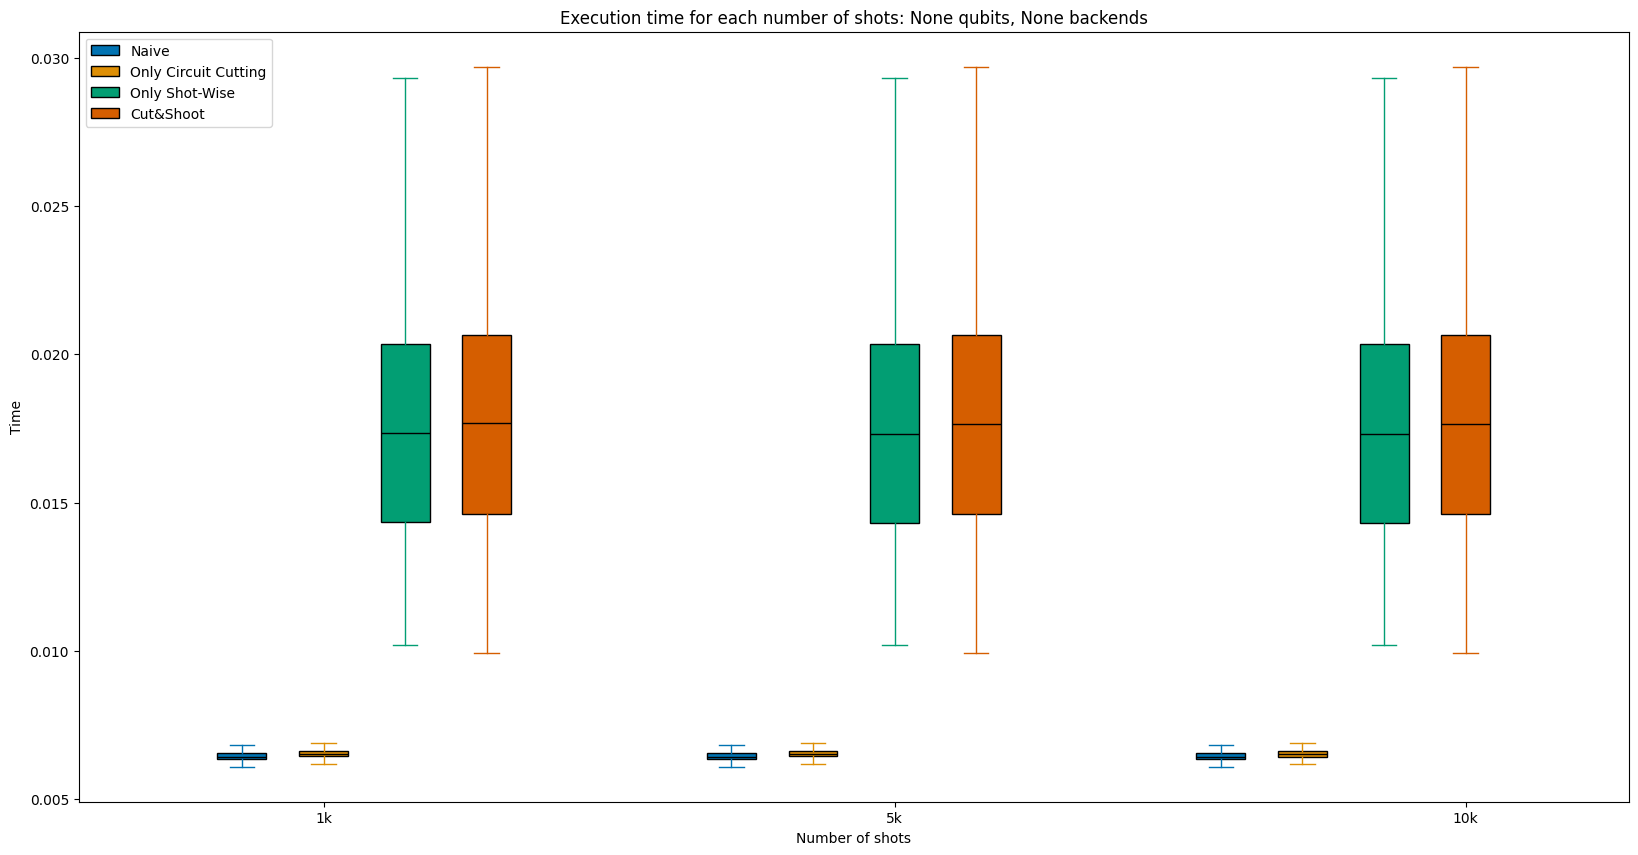

In [13]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

offset = 0
for exp_data_df in exp_data_dfs:
    data = exp_data_df.copy()
    
    if qubit_size:
        data = data[data["qubits"] == qubit_size]
    
    vanilla = data[data["strategy"] == "vanilla"]
    cc = data[data["strategy"] == "cc"]
    shot_wise = data[data["strategy"] == "sw"]
    if backend_size:
        shot_wise = shot_wise[shot_wise["num_backends"] == backend_size]
    cc_sw = data[data["strategy"] == "cc_sw"]
    if backend_size:
        cc_sw = cc_sw[cc_sw["num_backends"] == backend_size]
    
    color = colors["vanilla"]
    ax.boxplot(vanilla["execution_time"], positions=[offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
    if not vanilla.empty:
        offset += 0.25
    
    color = colors["cc"]
    ax.boxplot(cc["execution_time"], positions=[offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
    if not cc.empty:
        offset += 0.25
    
    color = colors["sw"]
    ax.boxplot(shot_wise["execution_time"], positions=[offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
    if not shot_wise.empty:
        offset += 0.25
        
    color = colors["cc_sw"]
    ax.boxplot(cc_sw["execution_time"], positions=[offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))

    offset += 0.75
    
ax.set_xlabel("Number of shots")
ax.set_ylabel("Time")
ax.set_title(f"Execution time for each number of shots: {qubit_size} qubits, {backend_size} backends")
ax.set_xticks(np.arange(len(exp_data_dfs)) * 1.75 + 0.25)
ax.set_xticklabels(exp_legend)

ax.legend([plt.Rectangle((0,0),1,1,fc=colors[strategy], ec="black") for strategy in ["vanilla", "cc", "sw", "cc_sw"]], [legend[strategy] for strategy in ["vanilla", "cc", "sw", "cc_sw"]])
plt.savefig(plots_dir + f"execution_time_full_{qubit_size}q_{backend_size}b.png")

plt.show()
    

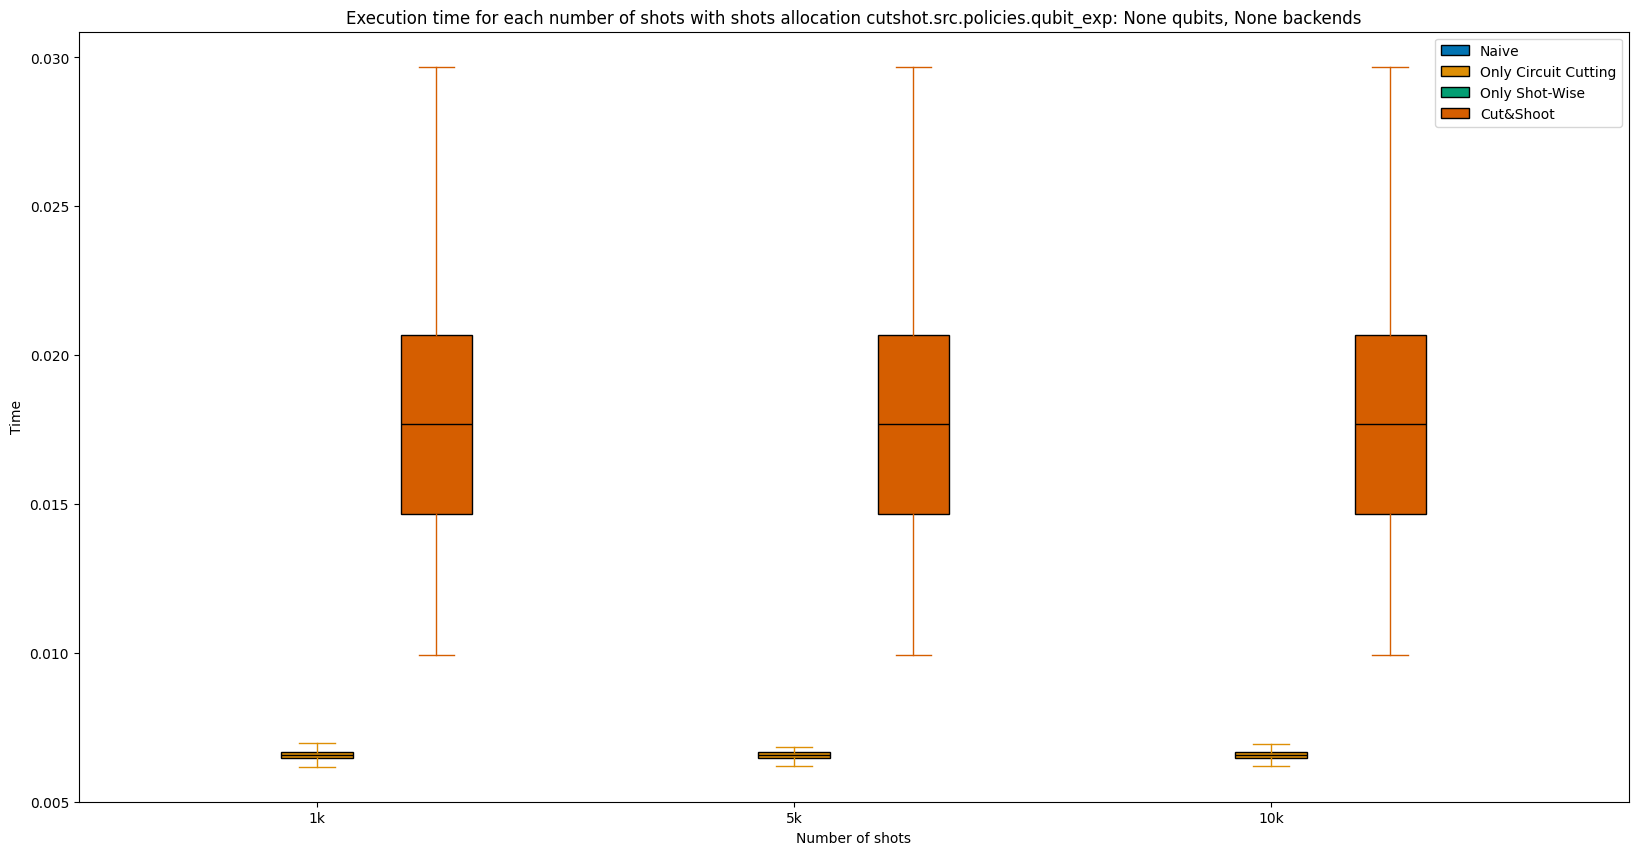

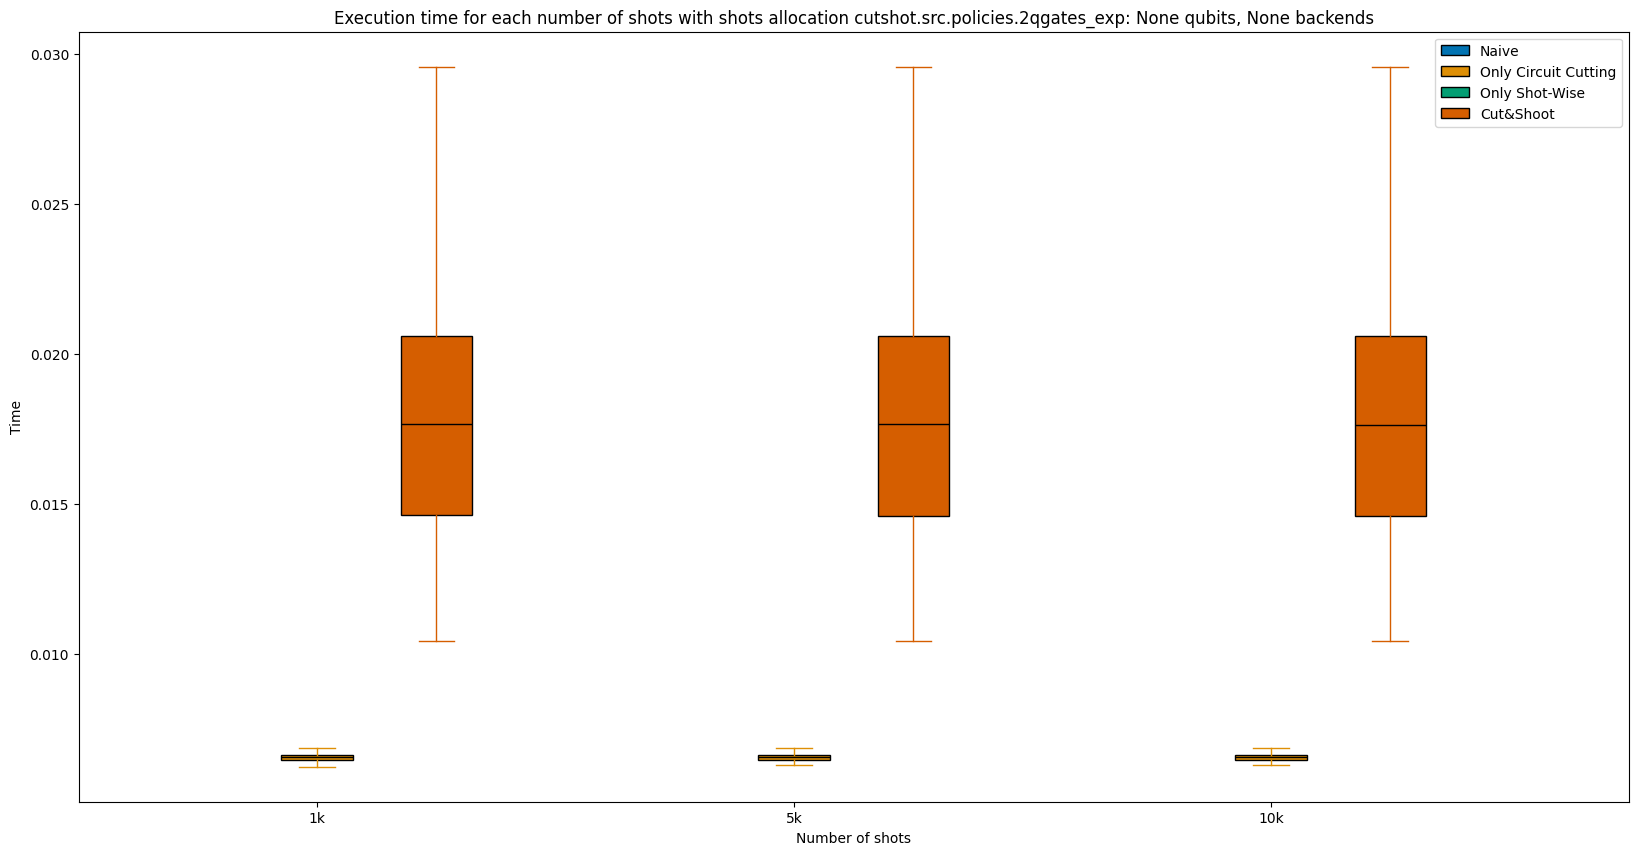

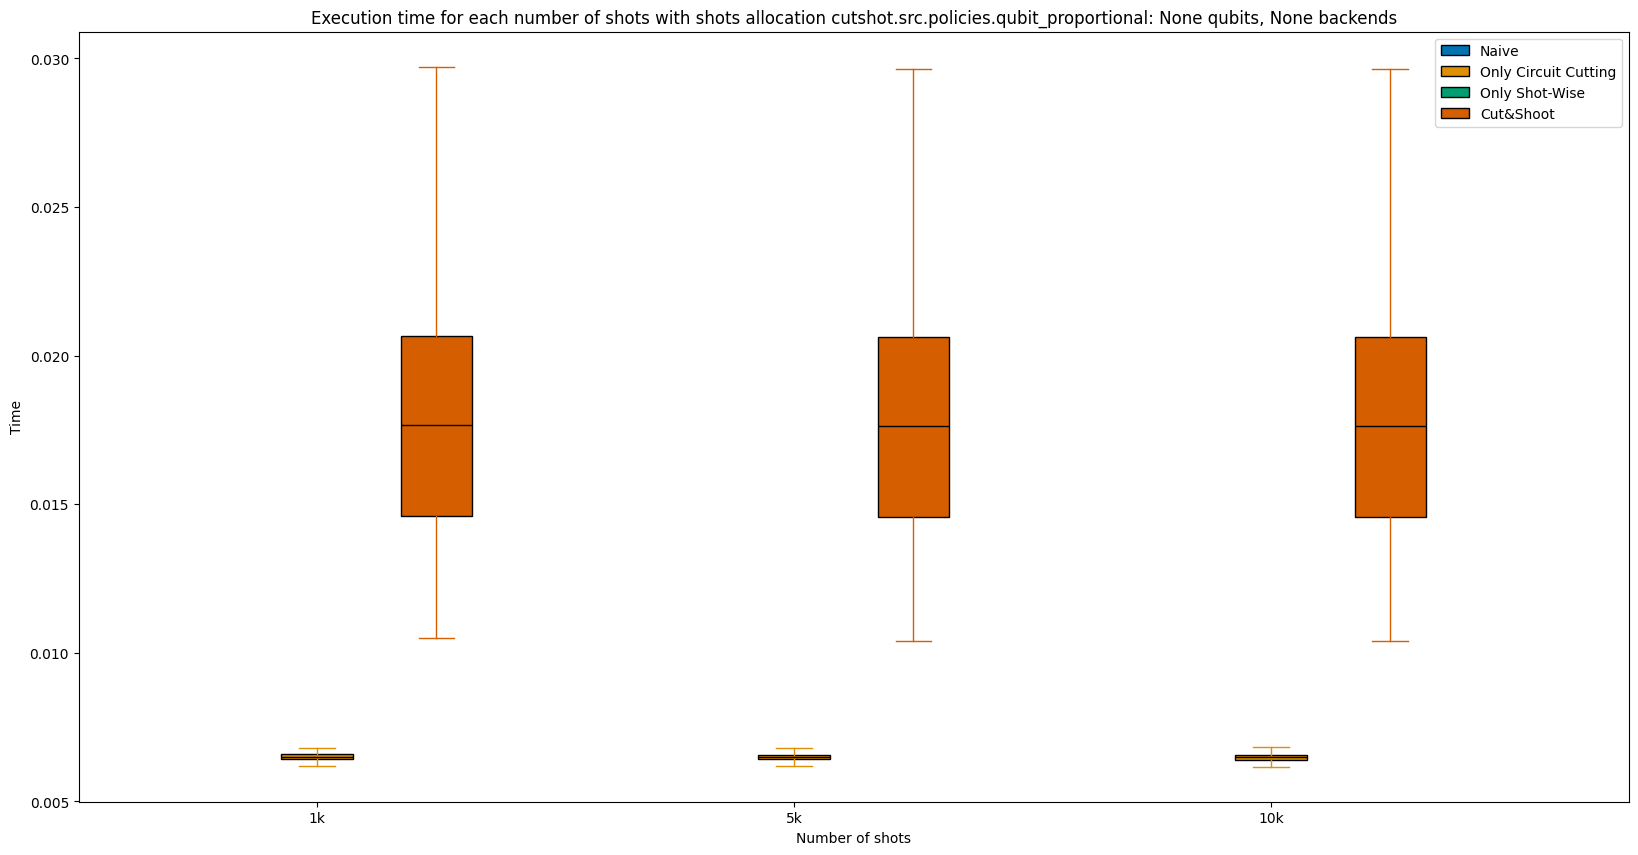

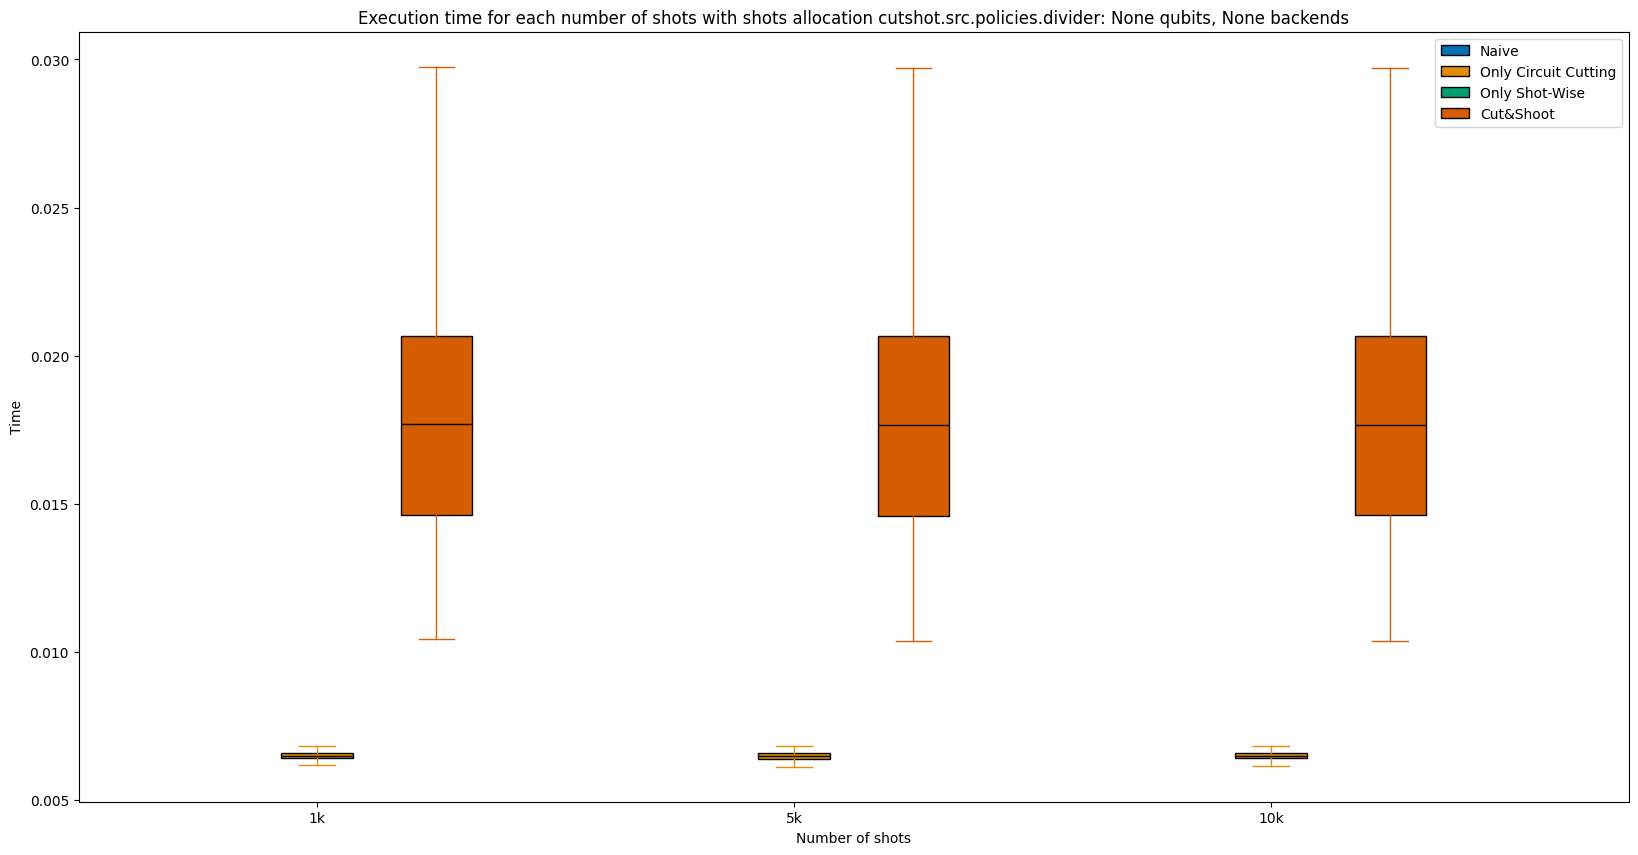

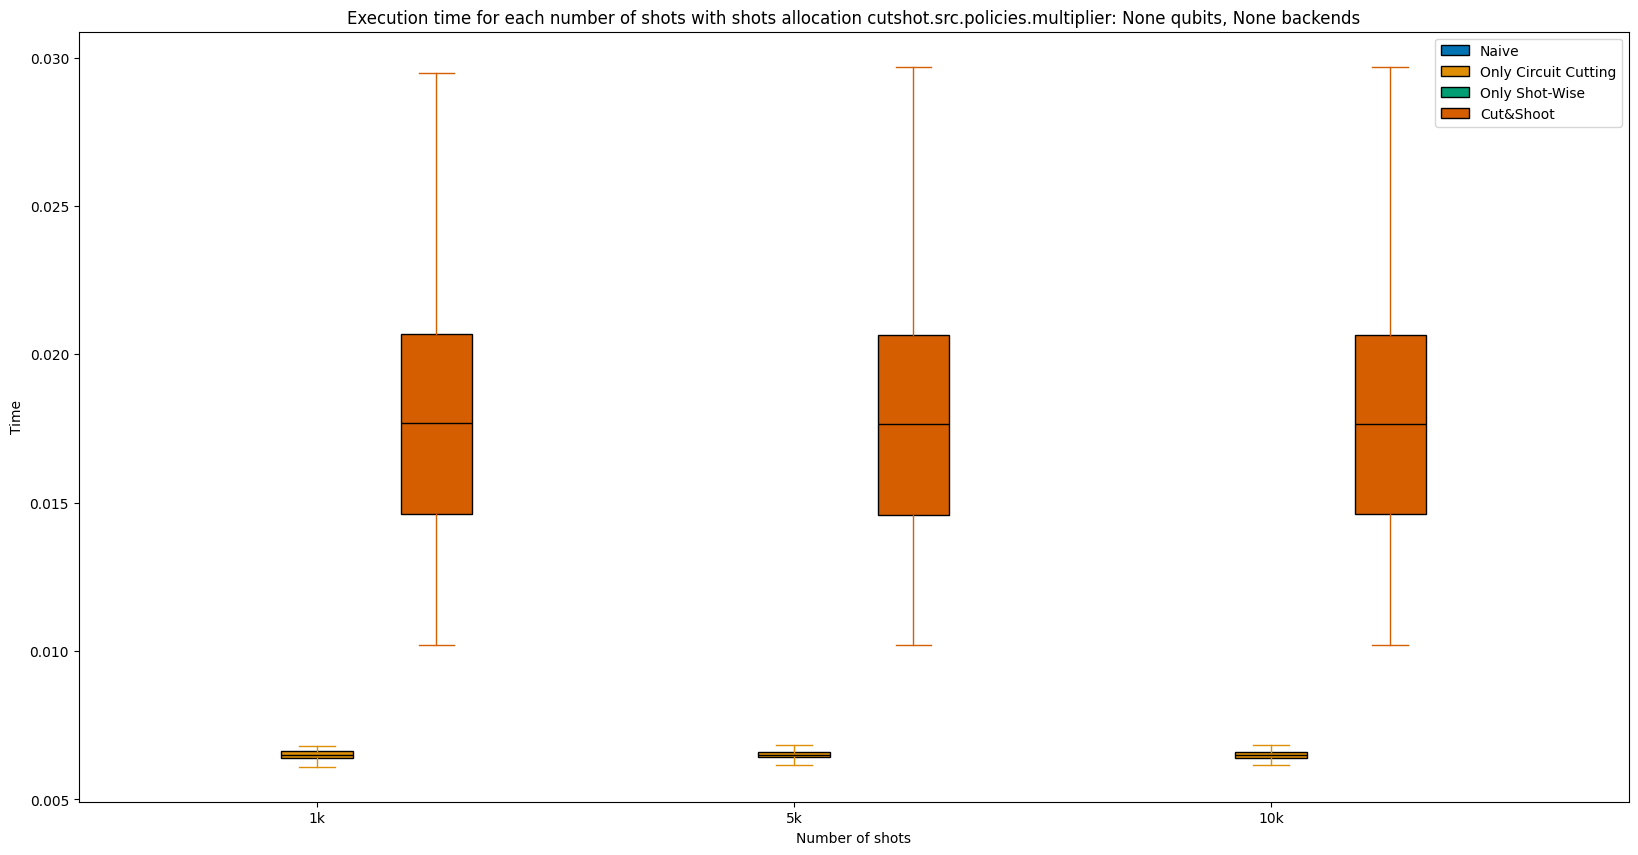

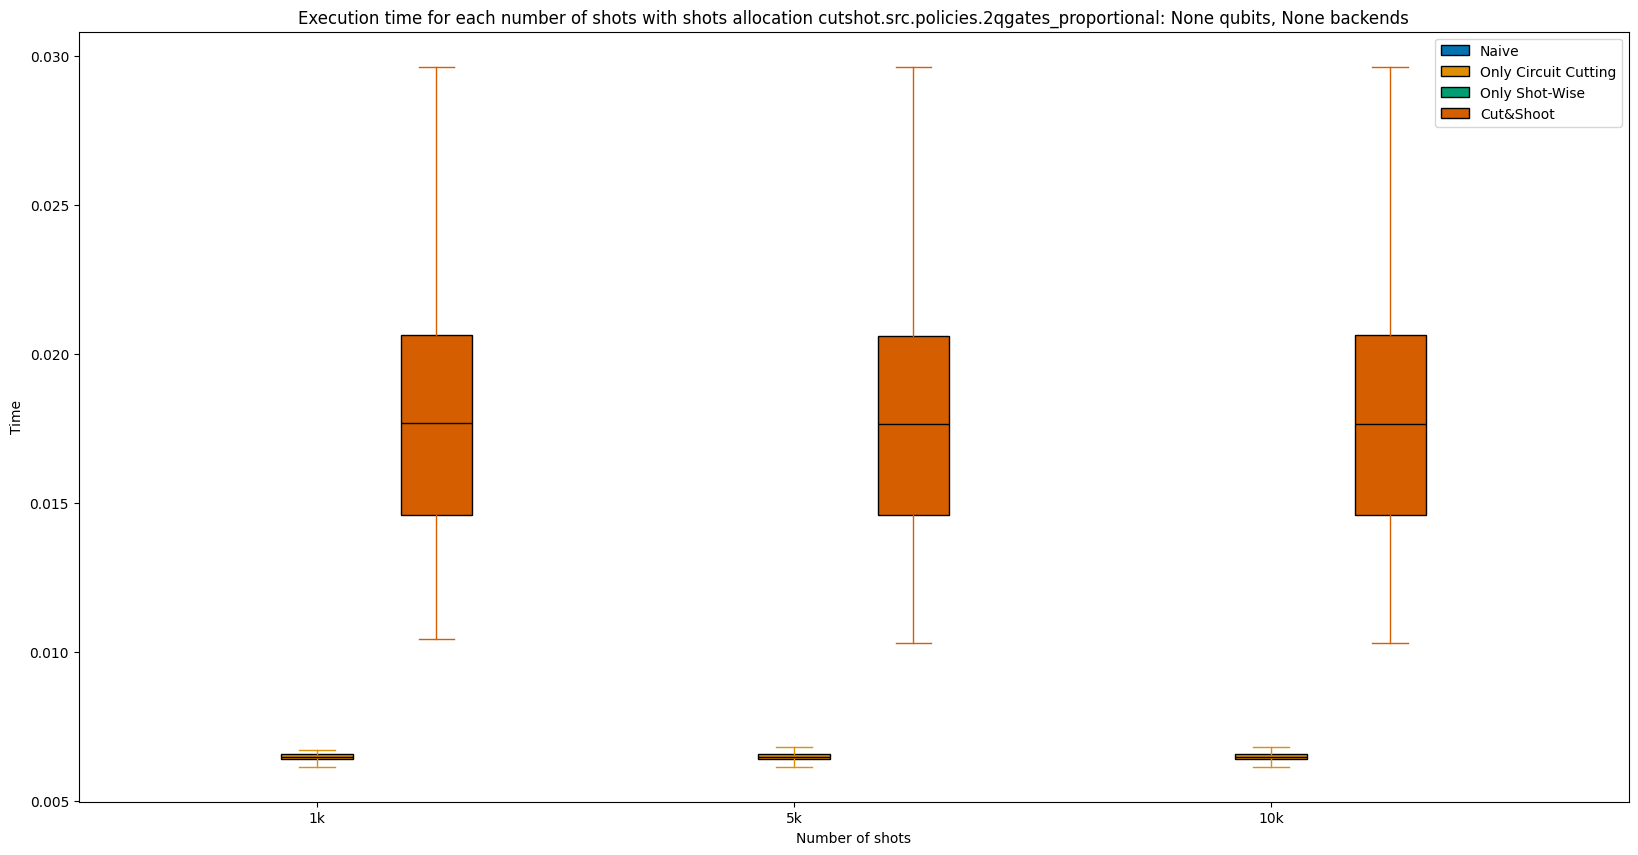

In [14]:
for sa in exp_data_df["shots_allocation"].unique():
    if sa is None:
        continue

    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)

    offset = 0
    for exp_data_df in exp_data_dfs:
        data = exp_data_df[exp_data_df["shots_allocation"] == sa]
        
        if qubit_size:
            data = data[data["qubits"] == qubit_size]
        
        vanilla = data[data["strategy"] == "vanilla"]
        cc = data[data["strategy"] == "cc"]
        shot_wise = data[data["strategy"] == "sw"]
        if backend_size:
            shot_wise = shot_wise[shot_wise["num_backends"] == backend_size]
        cc_sw = data[data["strategy"] == "cc_sw"]
        if backend_size:
            cc_sw = cc_sw[cc_sw["num_backends"] == backend_size]
        
        color = colors["vanilla"]
        ax.boxplot(vanilla["execution_time"], positions=[offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        if not vanilla.empty:
            offset += 0.25
        
        color = colors["cc"]
        ax.boxplot(cc["execution_time"], positions=[offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        if not cc.empty:
            offset += 0.25
        
        color = colors["sw"]
        ax.boxplot(shot_wise["execution_time"], positions=[offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        if not shot_wise.empty:
            offset += 0.25
            
        color = colors["cc_sw"]
        ax.boxplot(cc_sw["execution_time"], positions=[offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        
        offset += 0.75
        
    ax.set_xlabel("Number of shots")
    ax.set_ylabel("Time")
    ax.set_title(f"Execution time for each number of shots with shots allocation {sa}: {qubit_size} qubits, {backend_size} backends")
    ax.set_xticks(np.arange(len(exp_data_dfs)) * 1)
    ax.set_xticklabels(exp_legend)
    
    ax.legend([plt.Rectangle((0,0),1,1,fc=colors[strategy], ec="black") for strategy in ["vanilla", "cc", "sw", "cc_sw"]], [legend[strategy] for strategy in ["vanilla", "cc", "sw", "cc_sw"]])
    
    plt.savefig(plots_dir + f"execution_time_per_strategy_{sa}_{qubit_size}q_{backend_size}b.png")
    
    
    plt.show()
    

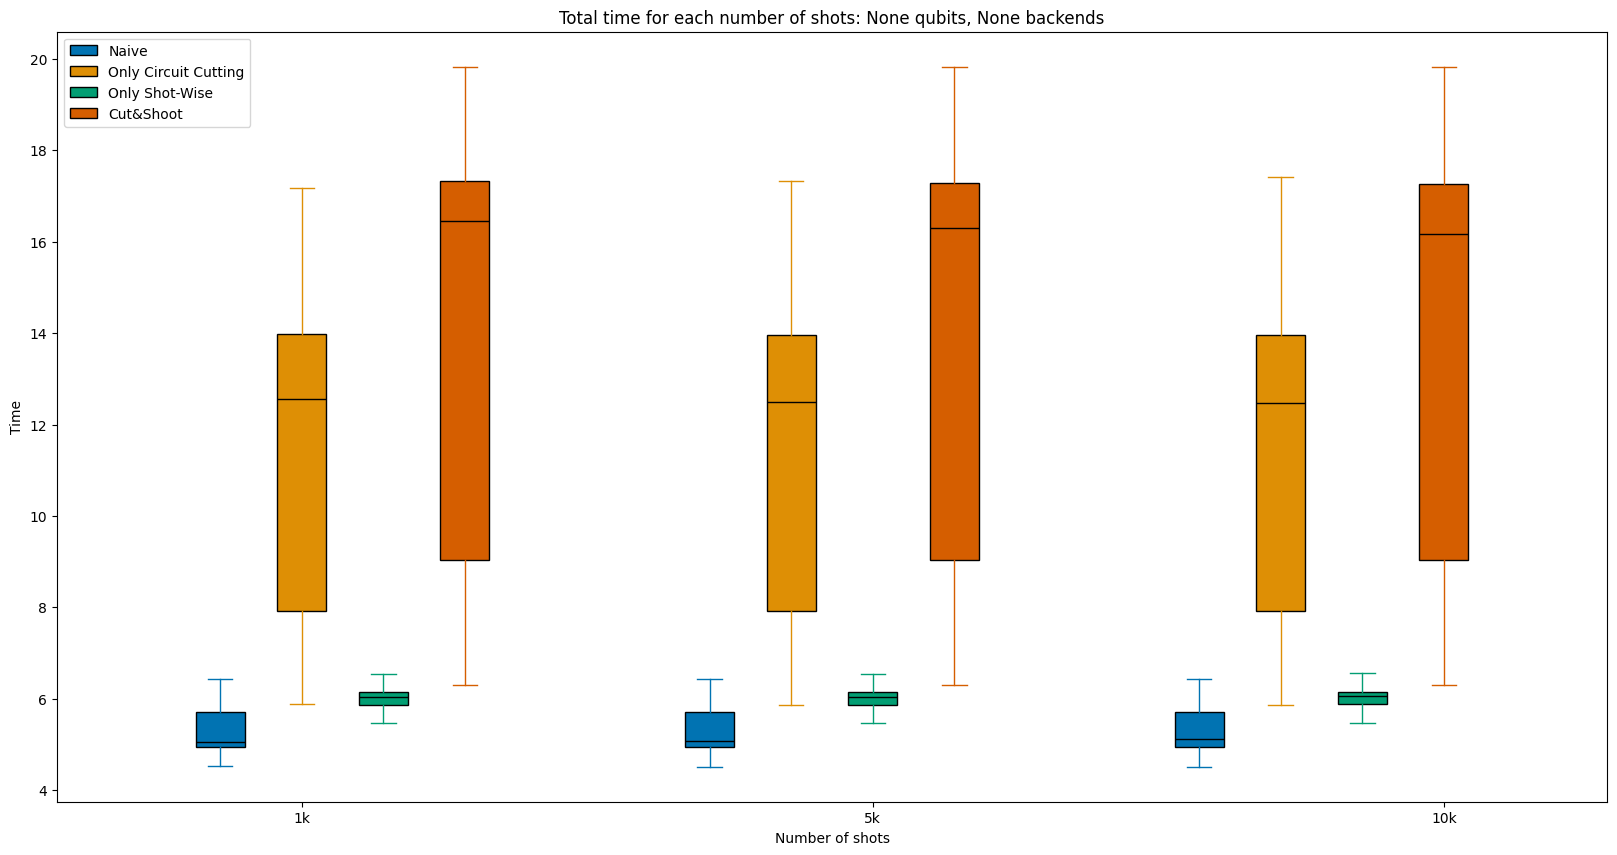

In [15]:

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

offset = 0
for exp_data_df in exp_data_dfs:
    data = exp_data_df.copy()
    
    if qubit_size:
        data = data[data["qubits"] == qubit_size]
    
    vanilla = data[data["strategy"] == "vanilla"]
    cc = data[data["strategy"] == "cc"]
    shot_wise = data[data["strategy"] == "sw"]
    if backend_size:
        shot_wise = shot_wise[shot_wise["num_backends"] == backend_size]
    cc_sw = data[data["strategy"] == "cc_sw"]
    if backend_size:
        cc_sw = cc_sw[cc_sw["num_backends"] == backend_size]
    
    color = colors["vanilla"]
    ax.boxplot(vanilla["time_total"], positions=[offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
    if not vanilla.empty:
        offset += 0.25
    
    color = colors["cc"]
    ax.boxplot(cc["time_total"], positions=[offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
    if not cc.empty:
        offset += 0.25
    
    color = colors["sw"]
    ax.boxplot(shot_wise["time_total"], positions=[offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
    if not shot_wise.empty:
        offset += 0.25
        
    color = colors["cc_sw"]
    ax.boxplot(cc_sw["time_total"], positions=[offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
    
    offset += 0.75
    
ax.set_xlabel("Number of shots")    
ax.set_ylabel("Time")
ax.set_title(f"Total time for each number of shots: {qubit_size} qubits, {backend_size} backends")

ax.set_xticks(np.arange(len(exp_data_dfs)) * 1.75 + 0.25)
ax.set_xticklabels(exp_legend)

ax.legend([plt.Rectangle((0,0),1,1,fc=colors[strategy], ec="black") for strategy in ["vanilla", "cc", "sw", "cc_sw"]], [legend[strategy] for strategy in ["vanilla", "cc", "sw", "cc_sw"]])

plt.savefig(plots_dir + f"time_total_full_{qubit_size}q_{backend_size}b.png")


plt.show()
    

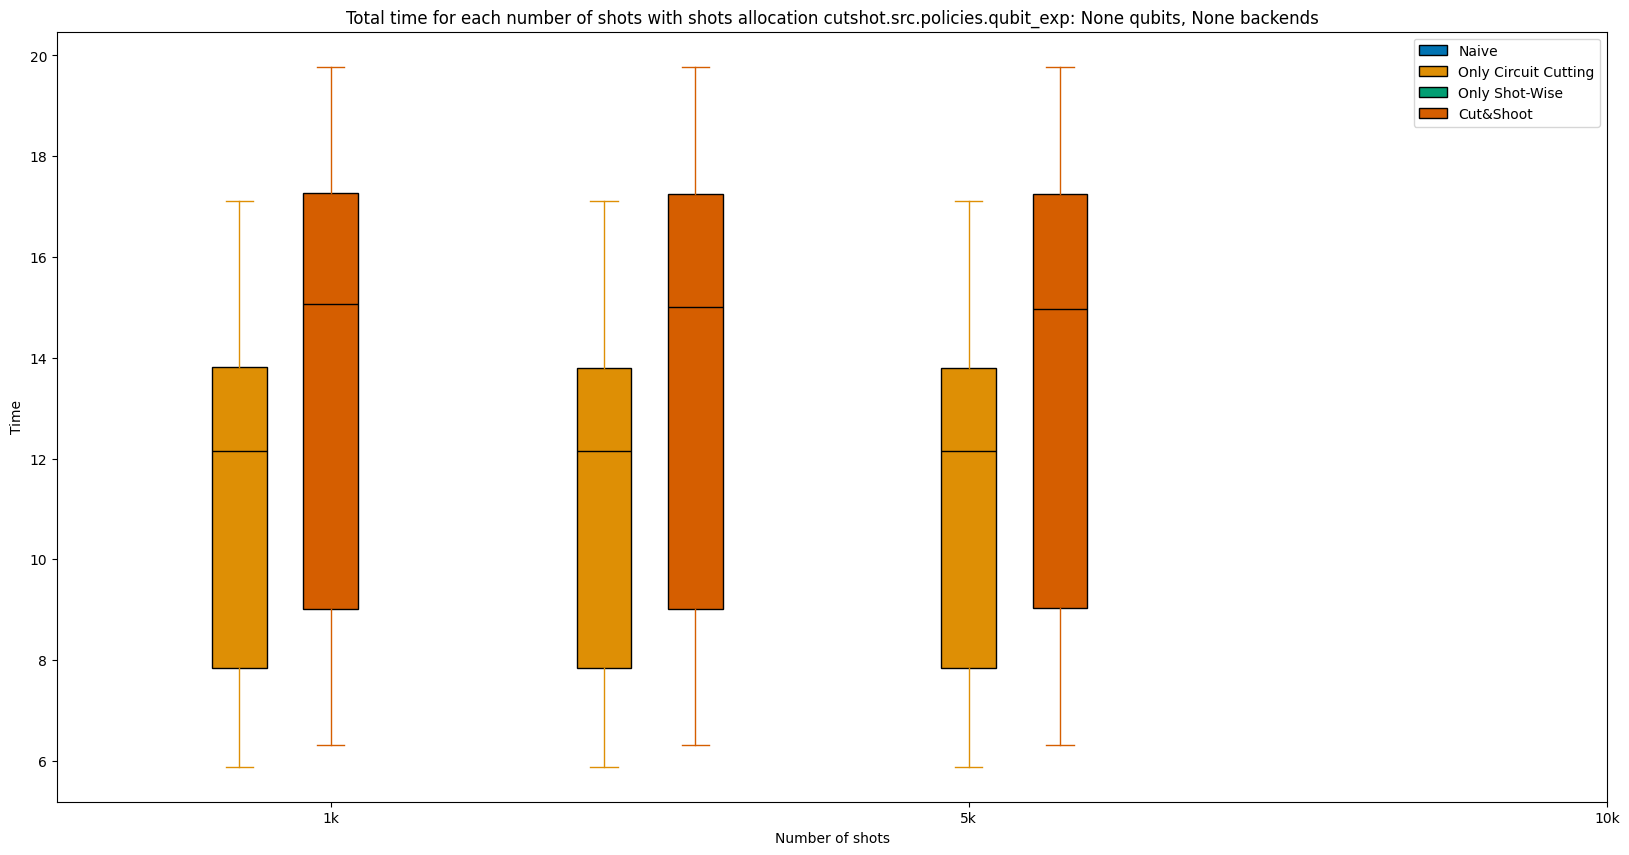

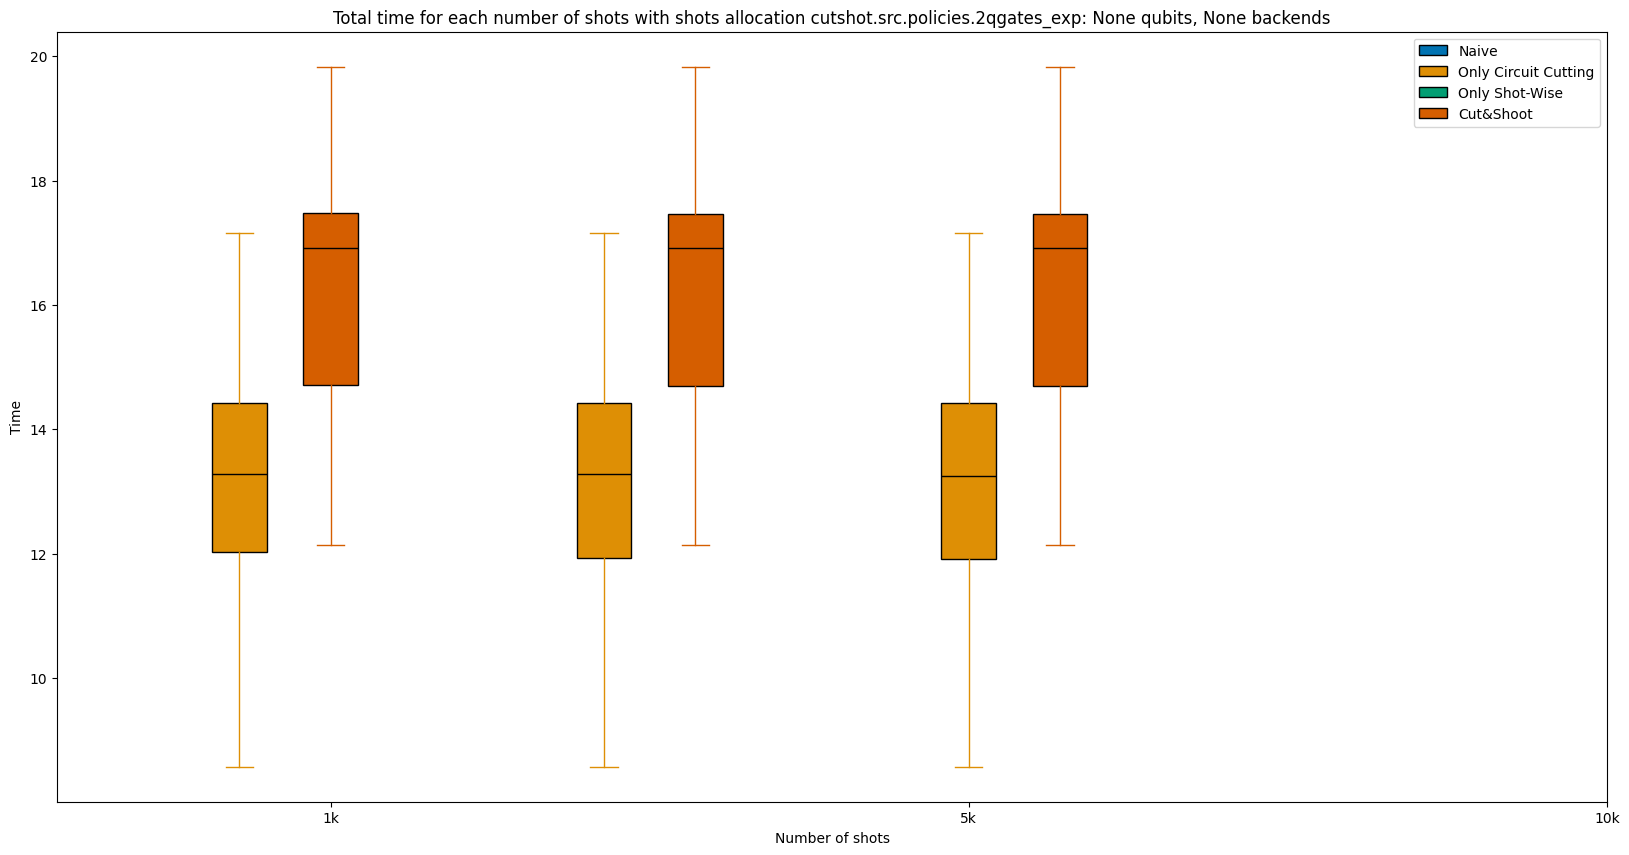

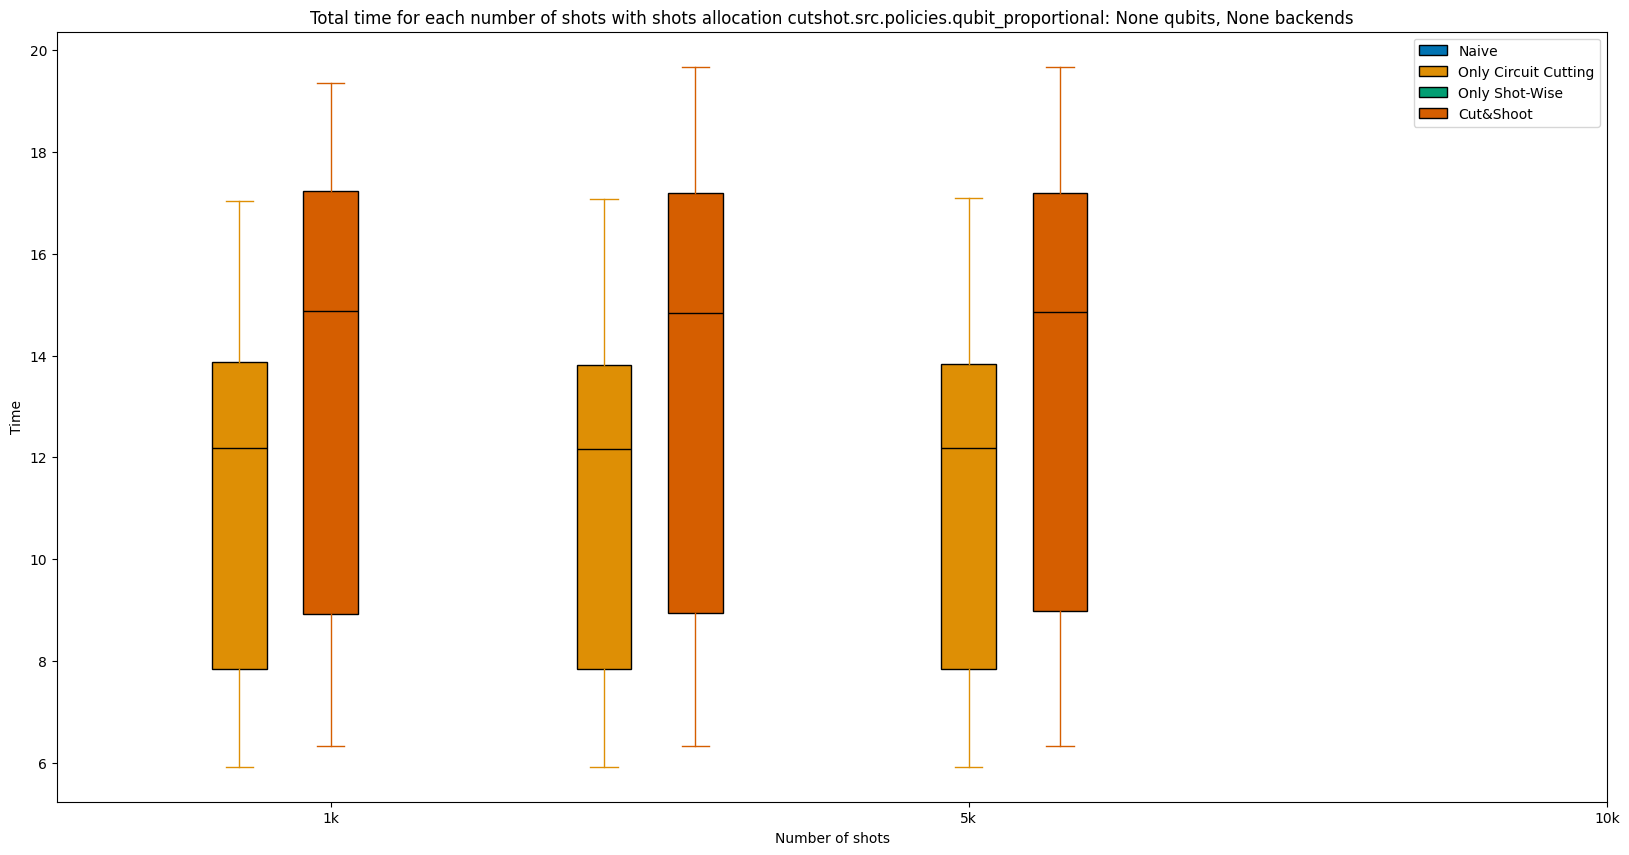

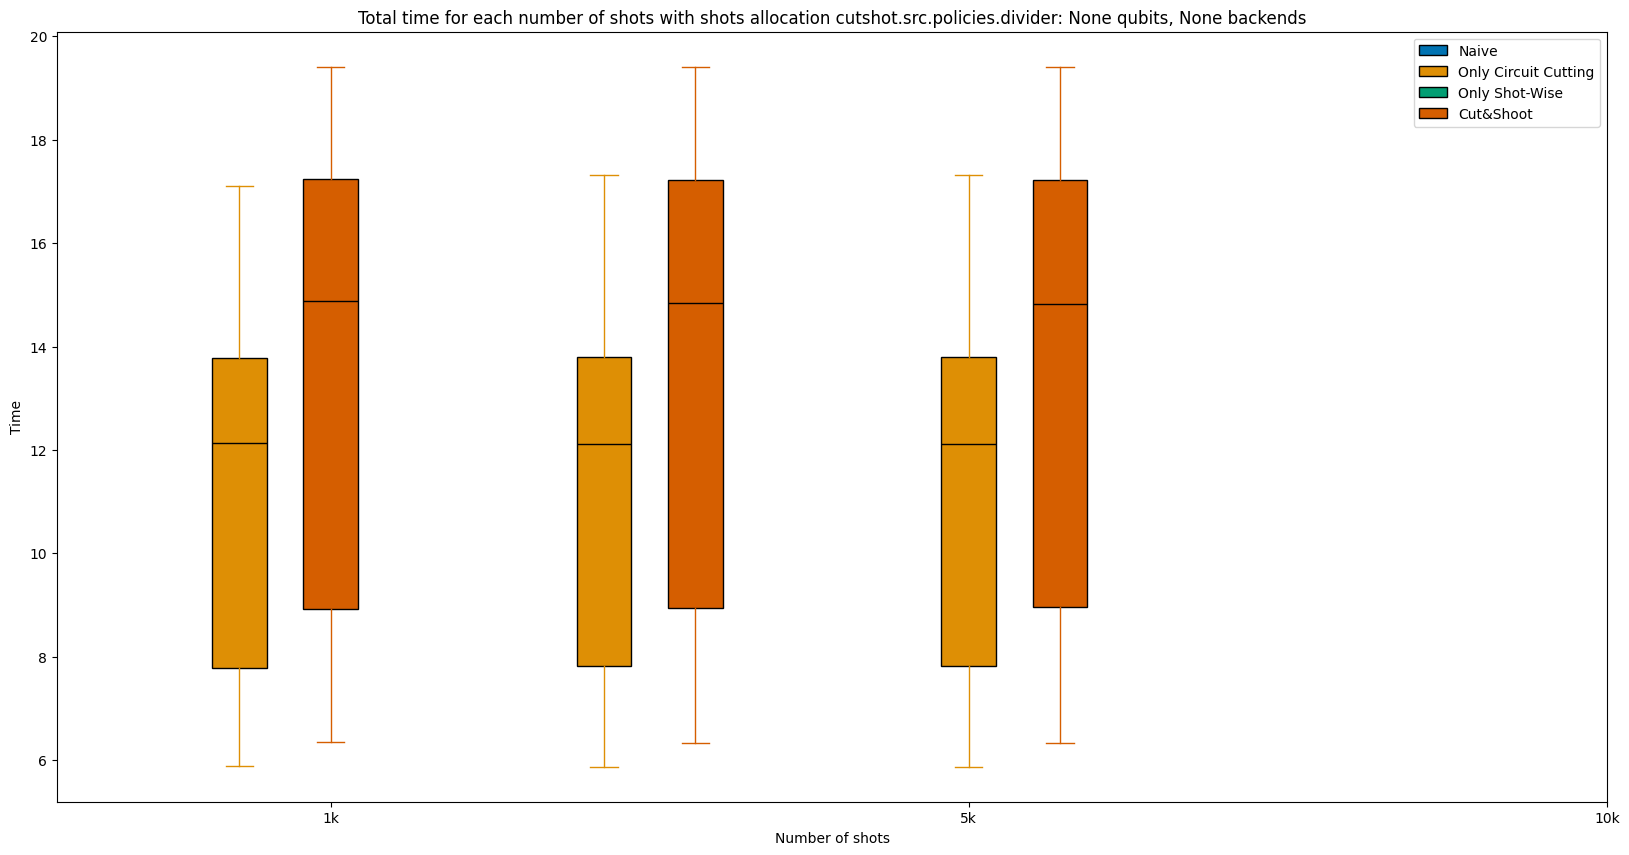

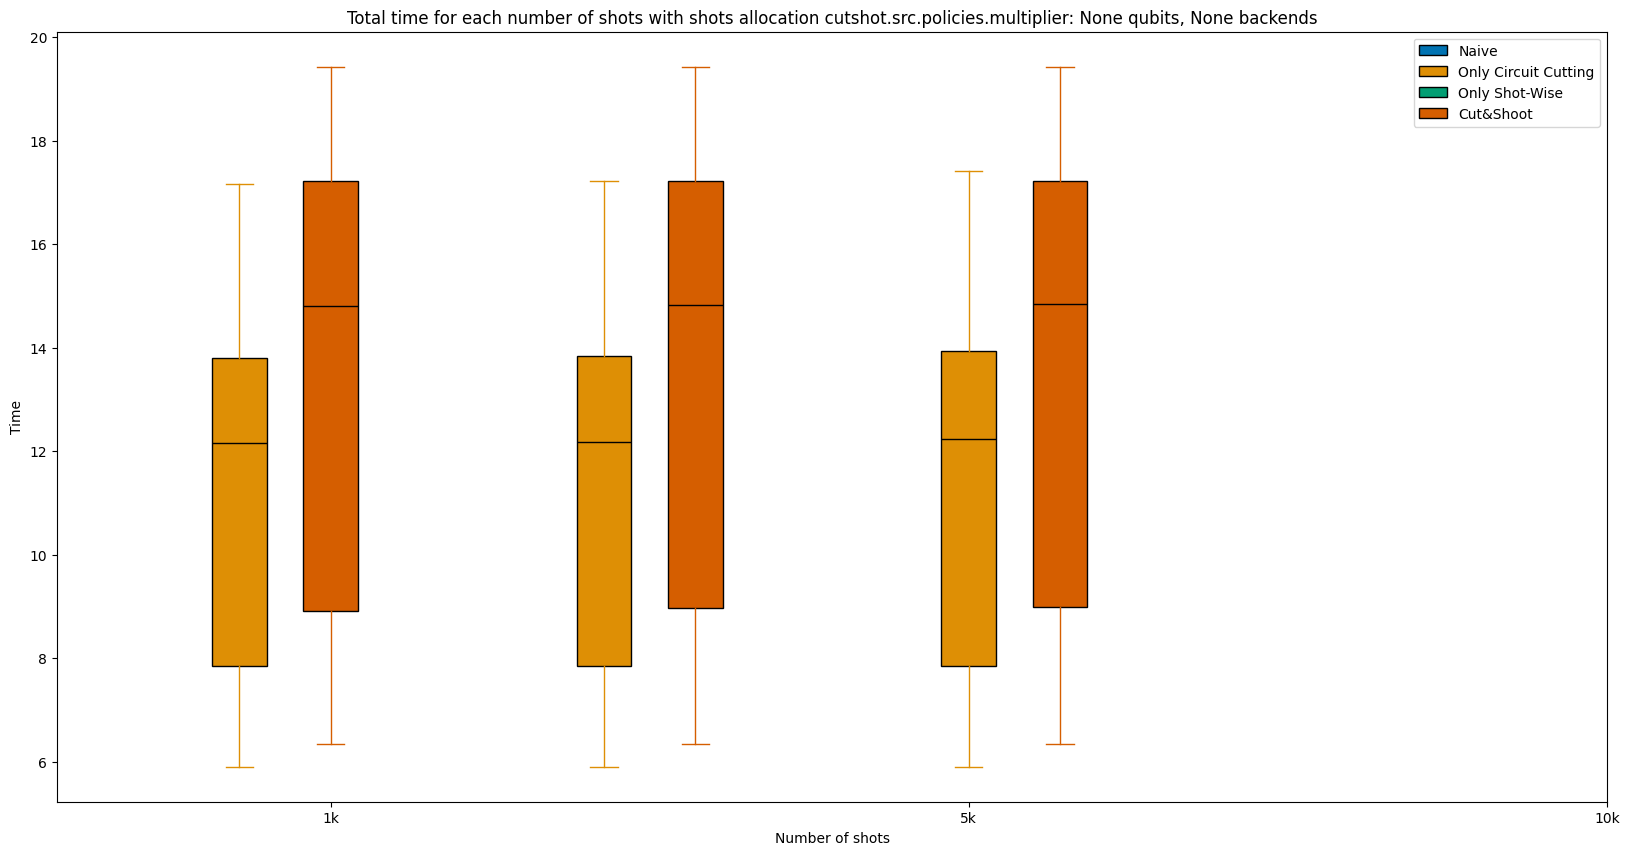

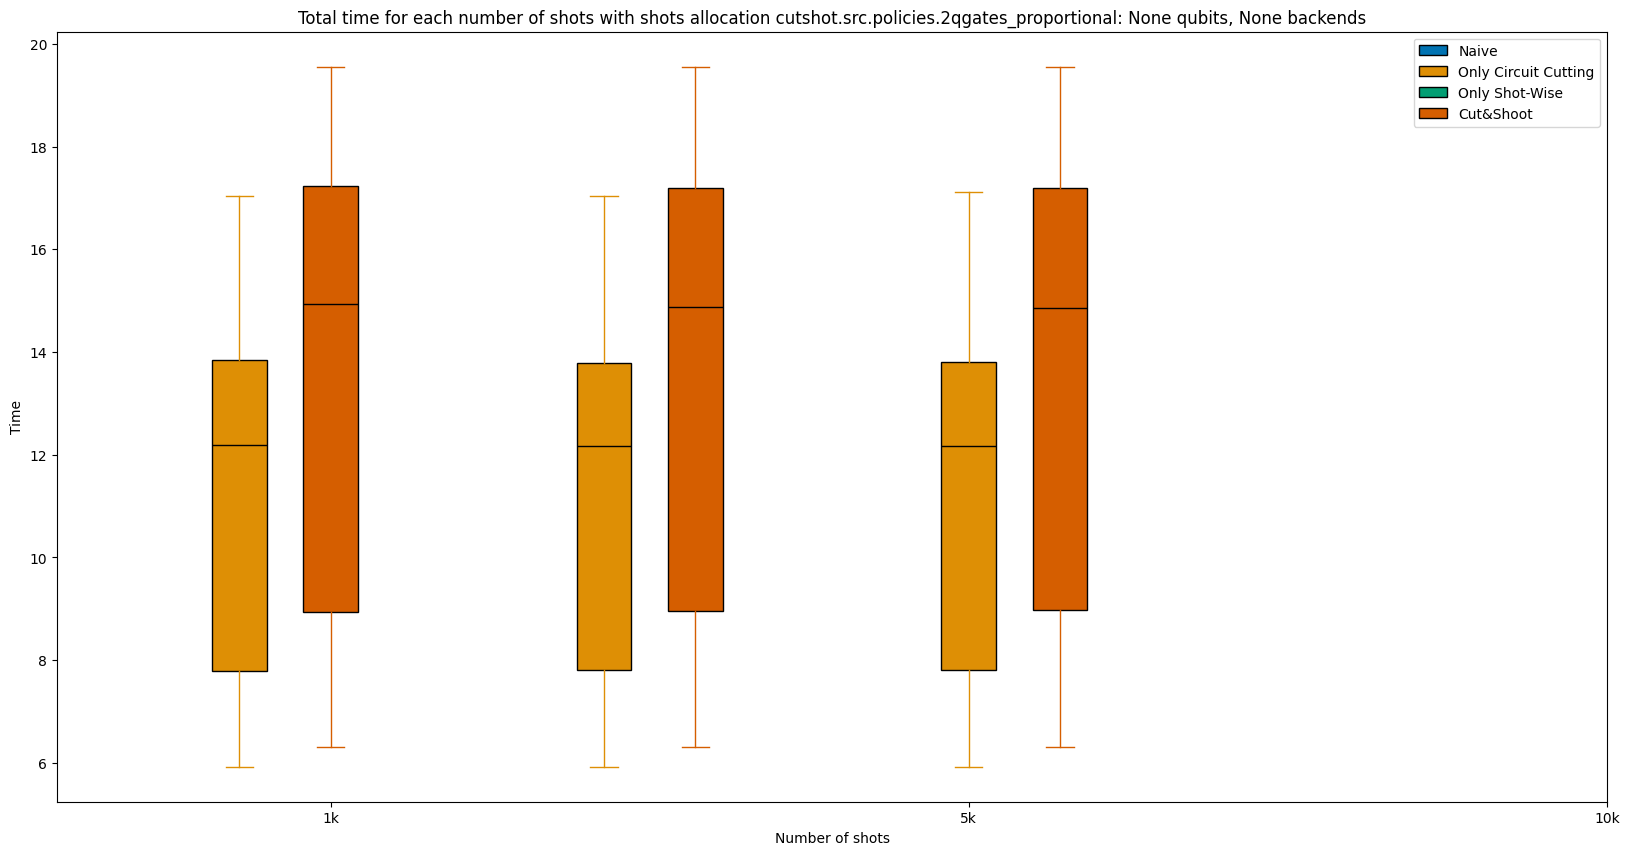

In [16]:
for sa in exp_data_df["shots_allocation"].unique():
    if sa is None:
        continue
    
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)

    offset = 0
    for exp_data_df in exp_data_dfs:
        data = exp_data_df[exp_data_df["shots_allocation"] == sa]
        
        if qubit_size:
            data = data[data["qubits"] == qubit_size]
        
        vanilla = data[data["strategy"] == "vanilla"]
        cc = data[data["strategy"] == "cc"]
        shot_wise = data[data["strategy"] == "sw"]
        if backend_size:
            shot_wise = shot_wise[shot_wise["num_backends"] == backend_size]
        cc_sw = data[data["strategy"] == "cc_sw"]
        if backend_size:
            cc_sw = cc_sw[cc_sw["num_backends"] == backend_size]
        
        color = colors["vanilla"]
        ax.boxplot(vanilla["time_total"], positions=[offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        if not vanilla.empty:
            offset += 0.25
        
        color = colors["cc"]
        ax.boxplot(cc["time_total"], positions=[offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        if not cc.empty:
            offset += 0.25
        
        color = colors["sw"]
        ax.boxplot(shot_wise["time_total"], positions=[offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        if not shot_wise.empty:
            offset += 0.25
            
        color = colors["cc_sw"]
        ax.boxplot(cc_sw["time_total"], positions=[offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        
        offset += 0.75
        
    ax.set_xlabel("Number of shots")
    ax.set_ylabel("Time")
    ax.set_title(f"Total time for each number of shots with shots allocation {sa}: {qubit_size} qubits, {backend_size} backends")
    
    ax.set_xticks(np.arange(len(exp_data_dfs)) * 1.75 + 0.25)
    ax.set_xticklabels(exp_legend)
    
    ax.legend([plt.Rectangle((0,0),1,1,fc=colors[strategy], ec="black") for strategy in ["vanilla", "cc", "sw", "cc_sw"]], [legend[strategy] for strategy in ["vanilla", "cc", "sw", "cc_sw"]])
    
    plt.savefig(plots_dir + f"time_total_per_strategy_{sa}_{qubit_size}q_{backend_size}b.png")
    
    plt.show()
    